# Function Regression

# Import

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam, SGD
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

import numpy as np
import random
import math

import time

import altair as alt
alt.data_transformers.disable_max_rows()
import pandas as pd
GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

random.seed(666)

Using cpu


# MFAN Network

In [ ]:
class MFAN(torch.nn.Module):
    def __init__(self,
                 x_in, x_lr,
                 y_in, y_lr, d_lr,
                 hid_dims,# 500, 300, 300
                 d_loss_func=torch.nn.CrossEntropyLoss(),
                 enc_ABC=[1,1,1]):
        super(MFAN, self).__init__()
        self.x_net = torch.nn.Sequential( torch.nn.Linear(x_in, hid_dims[0]) ).to(device) # 784_500
        self.y_net = torch.nn.Sequential( torch.nn.Linear(y_in, hid_dims[0]) ).to(device) # 784_500
        self.d_net = torch.nn.Sequential( torch.nn.Linear(hid_dims[0], y_in) ).to(device) # 500_10
        for i in range(len(hid_dims)-1):
            self.x_net.append( torch.nn.Linear( hid_dims[i], hid_dims[i+1]) ).to(device)
            self.y_net.append( torch.nn.Linear( hid_dims[i], hid_dims[i+1]) ).to(device)
            self.d_net.append( torch.nn.Linear( hid_dims[i+1], y_in) ).to(device)
        self.relu = torch.nn.ReLU()
        # optimizers, loss
        self.x_opt = Adam(self.x_net.parameters(), lr=x_lr)
        self.y_opt = Adam(self.y_net.parameters(), lr=y_lr)
        self.d_opt = Adam(self.d_net.parameters(), lr=d_lr)
        self.d_loss_func = d_loss_func
        self.A, self.B, self.C = enc_ABC

    def forward(self, x, y_pos, y_neg, layer_ind):
        Zx = self.x_net[layer_ind]( x ) # [60000, 500]
        Zys = self.y_net[layer_ind]( torch.cat([y_neg, y_pos],0) ) # [120000, 500]
        Zy_neg, Zy_pos = Zys[:len(y_neg)], Zys[len(y_pos):] # [60000, 500], [60000, 500]
        pos_sim = F.cosine_similarity(Zx, Zy_pos, dim=1) * self.A
        neg_sim = F.cosine_similarity(Zx, Zy_neg, dim=1) * self.B
        y_neg_similarity = F.cosine_similarity(Zy_neg, Zy_pos, dim=1) * self.C
        loss = (- pos_sim + neg_sim - y_neg_similarity).mean()
        # loss = (- pos_sim + neg_sim).mean()
        self.x_opt.zero_grad()
        self.y_opt.zero_grad()
        loss.backward()
        self.x_opt.step()
        self.y_opt.step()
        return Zx, Zy_pos, Zy_neg, loss.item()

    def d_forward(self, Zx, true_y_pos, layer_ind):
        y_pred = self.d_net[layer_ind]( Zx )
        # loss = self.d_loss_func(y_pred, true_y_pos)
        loss = torch.sqrt(self.d_loss_func(y_pred, true_y_pos))
        self.d_opt.zero_grad()
        loss.backward()
        self.d_opt.step()
        return y_pred, loss.item()

# Create_data()

In [ ]:
def get_y_neg(y, val_off=[0.3,0.2]):
    y_neg = y.clone()
    for i in range(len(y)):
        r = 1 if random.random() < 0.5 else -1
        y_neg[i] += r*val_off[0] + r*random.random() * val_off[1]
    return y_neg

def create_data(num_data=100, len_data=100, offset=[0.3,0.2], f=lambda x: np.sin(0.2*x), do_plot=False):
    x_data_tr, y_data_tr, y_data_tr_neg = [], [], []
    for i in range(num_data):
        xi = torch.linspace(0.1*i, 0.1*i+100, len_data)
        yi = f(xi)
        yi_neg = get_y_neg(yi, offset)
        x_data_tr.append(xi)
        y_data_tr.append(yi)
        y_data_tr_neg.append(yi_neg)

    x_data_te, y_data_te = [], []
    for i in range(num_data):
        xi = torch.linspace(0.1*i+100, 0.1*i+200, len_data)
        yi = f(xi)
        x_data_te.append(xi)
        y_data_te.append(yi)
    #-------plot-------
    if do_plot:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
        ax.set_title('Train data')
        ax.plot(x_data_tr[0], y_data_tr[0], '.-', label="positive")
        ax.plot(x_data_tr[0], y_data_tr_neg[0], 'x-', label='negative', c='orange')
        ax.legend(loc='lower left')

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
        ax.set_title('Data')
        ax.plot(x_data_tr[0], y_data_tr[0], 'x-', label="Train")
        ax.plot(x_data_te[0], y_data_te[0], '.-', label="Expected Extrapolation", c='C0', linewidth=10, alpha=0.5 )
        ax.legend(loc='lower left')
        plt.show()
    return x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te

# for fi in [lambda x: np.sin(0.2*x), lambda x: np.cos(0.2*x), lambda x: np.sin(0.4*np.cos(0.2*x)), lambda x: np.sin(0.4*np.cos(0.2*x)+30), lambda x: np.sin(0.8*np.cos(0.2*x)+20), lambda x: np.cos(0.4*np.sin(0.2*x)+3)]:
#     _, _, _, _, _ = create_data(num_data=100, len_data=100, offset=[0.01,0.02], f=fi, do_plot=True)

# x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100, len_data=100, offset=[0.05, 0.1], f=lambda x: np.sin(0.2*x), do_plot=True)


# (Baseline) BP Network


In [ ]:
# Baseline back-propagation based model
class BPNet(torch.nn.Module):
    def __init__(self, dims, b=120, epoch=50, loss_func=F.cross_entropy, lr=1e-2):
        super(BPNet, self).__init__()
        self.model_linear = torch.nn.Sequential()
        for i in range(len(dims)-2): # dims len=5, range is 0-3
            self.model_linear.append(torch.nn.Linear(dims[i],dims[i+1]))
            self.model_linear.append(torch.nn.LayerNorm(dims[i+1]),)
            self.model_linear.append(torch.nn.ReLU())
        self.model_linear.append(torch.nn.Linear(dims[-2],dims[-1]))
        self.model_linear.append(torch.nn.LayerNorm(dims[-1]))

        self.opt = torch.optim.Adam(self.model_linear.parameters(), lr=lr)
        self.epochs = epoch
        self.loss_func = loss_func
        self.batch_size = b

    def do_train(self, x, y):
        batch_size = self.batch_size
        model_linear = self.model_linear
        loss_func = self.loss_func
        opt = self.opt
        for epoch in tqdm(range(self.epochs), desc='Train num_iter_batch'+str(x.shape[0]//batch_size) ):
            for i in (range((x.shape[0]-1)//batch_size + 1)):
                start_i = i * batch_size
                end_i = start_i + batch_size
                xb = x[start_i:end_i]
                yb = y[start_i:end_i]
                pred = model_linear(xb)
                loss = self.loss_func(pred, yb)
                loss.backward()
                opt.step() # Updating weights.
                opt.zero_grad()
    def do_eval(self, x_tr, y_tr, x_te, y_te, plot_i=0):
        with torch.no_grad():
            y_pred_tr = self.model_linear(x_tr).detach().cpu()
            y_pred_te = self.model_linear(x_te).detach().cpu()

            eval_mse_tr = np.sqrt(((y_pred_tr[plot_i]-y_tr[plot_i])**2).mean()).item() # error measure
            eval_mse_te = np.sqrt(((y_pred_te[plot_i]-y_te[plot_i])**2).mean()).item() # error measure
            eval_mse_te_avg = np.sqrt(((y_pred_te-y_te)**2).mean()).item() # error measure


            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
            ax[0].set_title("BP Train Result")
            ax[0].plot(x_tr[plot_i], y_tr[plot_i], '.-', label='Train') # ax.plot(x_tr[0], y_tr_neg[0], 'x-', label='negative')
            ax[0].plot(x_tr[plot_i], y_pred_tr[plot_i].detach().cpu().numpy(), '--', label='Train predicted')
            ax[0].legend()
            # ======= plot test eval
            ax[1].set_title("BP Test Result")
            ax[1].plot(x_te[plot_i], y_te[plot_i], '.-', label='Test')
            ax[1].plot(x_te[plot_i], y_pred_te[plot_i].detach().cpu().numpy(), '--', label='Test predicted')
            ax[1].legend()
            print('eval_mse: tr=',eval_mse_tr)
            print('eval_mse: te=',eval_mse_te)
            print('eval_mse avg: te avg=',eval_mse_te_avg)
            return y_pred_te[plot_i].detach().cpu().numpy(), eval_mse_te

# Train()

In [ ]:
# Function Train the MFAN model and collect training results#
def do_train(model, x, y_pos, y_neg, enc_batch_size=50, dec_batch_size=50, e_num_epoch=200, d_num_epoch=200):
    model.train()
    loss_dict = {'encoder':[], 'e_losses':[], 'e_batch_loss': [], 'e_all_l': [], 'e_all_loss':[],
                'decoder':[], 'd_losses':[], 'd_batch_loss': [], 'd_all_l': [], 'd_all_loss':[]}
    Zx_layers_tr = [] # store for Decoder training
    # ----------------------- Encoder ---------------------------
    for li in range(len(model.x_net)):
        Zx_layer_data_tr = []
        loss_dict['e_batch_loss'], loss_dict['e_all_l'] = [], []
        # for _ni in tqdm(range(e_num_epoch),
        #                 desc='Encode '+str(li+1)+'/'+str(len(model.x_net))+' layer; num_iter_batch='+str(x.shape[0]//enc_batch_size)):
        for _ni in range(e_num_epoch):
            Zx, Zy_pos, Zy_neg = [], [], []
            loss_dict['e_losses'] = []
            for i in range(x.shape[0]//enc_batch_size):
                start_i = i * enc_batch_size
                end_i = start_i + enc_batch_size
                xb, y_posb, y_negb = x[start_i:end_i], y_pos[start_i:end_i], y_neg[start_i:end_i]
                Zxb, Zy_posb, Zy_negb, _loss = model.forward(xb, y_posb, y_negb, li)
                loss_dict['e_losses'].append(_loss)
                loss_dict['e_all_l'].append(_loss)
                if Zx == []:
                    Zx, Zy_pos, Zy_neg = Zxb, Zy_posb, Zy_negb
                else:
                    Zx, Zy_pos, Zy_neg = torch.cat((Zx,Zxb),0), torch.cat((Zy_pos,Zy_posb),0), torch.cat((Zy_neg,Zy_negb),0)
            #-----end batch for
            loss_dict['e_batch_loss'].append(np.mean(loss_dict['e_losses']))
            Zx_layer_data_tr = Zx.detach() # use only the last n_epoch's Zx to train decoder
        #-----end num_epoches for
        Zx_layers_tr.append(Zx_layer_data_tr)
        loss_dict['encoder'].append(loss_dict['e_batch_loss'])
        loss_dict['e_all_loss'].append(loss_dict['e_all_l'])

        x, y_pos, y_neg = model.relu(F.normalize(Zx)).detach(), model.relu(F.normalize(Zy_pos)).detach(), model.relu(F.normalize(Zy_neg)).detach()
    #-----end layer for
    # ----------------------- Decoder ---------------------------
    for li in range(len(model.x_net)):
        loss_dict['d_batch_loss'], loss_dict['d_all_l'] = [], []
        # for _ni in tqdm(range(d_num_epoch),
        #                 desc='Decode '+str(li+1)+'/'+str(len(model.x_net))+' layer; num_iter_batch='+str(Zx_layers_tr[0].shape[0]//dec_batch_size)):
        for _ni in range(d_num_epoch):
            Zx_tr = Zx_layers_tr[li]
            y_pos = torch.from_numpy(np.array(y_data_tr)).to(device)
            loss_dict['d_losses'] = []
            for i in range(Zx_tr.shape[0]//dec_batch_size):
                start_i = i * dec_batch_size
                end_i = start_i + dec_batch_size
                Zx_trb, y_posb = Zx_tr[start_i:end_i], y_pos[start_i:end_i]
                y_predb, _loss = model.d_forward(Zx_trb, y_posb, li)
                loss_dict['d_losses'].append(_loss)
                loss_dict['d_all_l'].append(_loss)
            #-----end batch for
            loss_dict['d_batch_loss'].append(np.mean(loss_dict['d_losses']))
        #-----end num_epoches for
        loss_dict['decoder'].append(loss_dict['d_batch_loss'])
        loss_dict['d_all_loss'].append(loss_dict['d_all_l'])
    #-----end layer for
    return model, loss_dict

In [ ]:
# Function tracking the MFAN encoder, decoder loss if needed #
def plot_loss(model, loss_dict):
    n_col = len(model.x_net)
    fig, axes = plt.subplots(nrows=1, ncols=n_col, figsize=(10, 2))
    for i in range(n_col):
        axes[i].plot(loss_dict['encoder'][i])
        axes[i].set_title('Encoder Loss L'+str(i))

    fig, axes = plt.subplots(nrows=1, ncols=n_col, figsize=(10, 2))
    for i in range(n_col):
        axes[i].plot(loss_dict['decoder'][i])
        axes[i].set_title('Decoder Loss L'+str(i))
# plot_loss(model, loss_dict)

# Eval()

In [ ]:
# Function evaluate the MFAN model and collect train and test results#
def do_eval(model, y_tr_eval, x_tr_eval, y_te_eval, x_te_eval, plot_i=0, comp='e'):
    model.eval()
    plot_x_tr, plot_y_tr= x_tr_eval[plot_i].clone(), y_tr_eval[plot_i].clone()
    plot_x_te, plot_y_te= x_te_eval[plot_i].clone(), y_te_eval[plot_i].clone()
    # ================================ EVAL ========================================
    y_pred_layers, y_pred_layers_te = [], []
    eval_mse, eval_mse_te = [], []
    for i in range(len(model.d_net)):
        with torch.no_grad():
            #------train eval
            Zx_tr_eval = model.x_net[i](x_tr_eval)
            y_pred_tr = model.d_net[i](Zx_tr_eval)
            y_pred_layers.append(y_pred_tr)
            eval_mse.append(np.sqrt(((y_pred_tr-y_tr_eval)**2).mean()).item()) # error measure
            x_tr_eval = model.relu(F.normalize(Zx_tr_eval)).detach()
            #------test eval
            Zx_te_eval = model.x_net[i](x_te_eval)
            y_pred_te = model.d_net[i](Zx_te_eval)
            y_pred_layers_te.append(y_pred_te)
            eval_mse_te.append(np.sqrt(((y_pred_te[plot_i]-y_te_eval[plot_i])**2).mean()).item()) # error measure
            x_te_eval = model.relu(F.normalize(Zx_te_eval)).detach()
    # ======= plot train eval
    n_layer = len(model.x_net)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
    ax[0].set_title("MFAN Train Result")
    ax[0].plot(plot_x_tr, plot_y_tr, '.-', label='Train')
    for i in range(1,n_layer):
        ax[0].plot(plot_x_tr, y_pred_layers[i][plot_i].detach().cpu().numpy(), '.-', label='pred_L'+str(i))
    ax[0].legend()
    # ======= plot test eval
    ax[1].set_title("MFAN Test Result")
    ax[1].plot(plot_x_te, plot_y_te, '.-', label='Expected Extrapolation',linewidth=10, alpha=0.5)
    for i in range(1,n_layer):
        ax[1].plot(plot_x_te, y_pred_layers_te[i][plot_i].detach().cpu().numpy(), '.-', label='pred_L'+str(i))
    ax[1].legend()
    # ======= print error eval

    j = np.argmin(eval_mse)
    if comp=='e':
        off_sets = [2,1]
    if comp=='h':
        off_sets = [3,2,1]
    for fs in off_sets:
        if j < len(eval_mse)-fs:
            j += fs
            break

    te_err = eval_mse_te[j]
    print('eval_mse: tr=',eval_mse)
    print('eval_mse: te=',eval_mse_te, ' L', j, ': ', te_err)
    return y_pred_layers_te[j][plot_i].detach().cpu().numpy(), "L"+str(j), te_err

# get_results()

In [ ]:
# Main function uses train(), eval() etc. to train the MFAN and BP models.
# It collects comparative results and plot them into illustrative graphs
def get_results(mfan_lr=[1e-3, 1e-3, 1e-3], BP_lr=1e-2, comp='e'):
    x_tr, y_tr, y_tr_neg = torch.from_numpy(np.array(x_data_tr)).to(device), torch.from_numpy(np.array(y_data_tr)).to(device), torch.from_numpy(np.array(y_data_tr_neg)).to(device)
    x_te, y_te = torch.from_numpy(np.array(x_data_te)).to(device), torch.from_numpy(np.array(y_data_te)).to(device)
    y_tr_eval, x_tr_eval = y_tr.clone().to(device), x_tr.clone().to(device) # train
    y_te_eval, x_te_eval = y_te.clone().to(device), x_te.clone().to(device) # test

    MFAN_lrx, MFAN_lry, MFAN_lrd = mfan_lr
    MFAN_dim, MFAN_enc_ABC = [128,128,64,64,32,32], [.6,.4,.6]
    BP_lr=1e-2 #eval_mse: tr= 0.6162347197532654 eval_mse: te= 0.15104486048221588

    BP_b=100
    BP_epoch=200
    MFAN_enc_batch_size=100
    MFAN_dec_batch_size=100
    MFAN_e_num_epoch=250
    MFAN_d_num_epoch=250
    # BP>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>eval_mse: tr= 0.6160585284233093     eval_mse: te= 0.1513572782278061
    print('------------------BP----------------------')
    x, y = x_tr.clone().to(device), y_tr.clone().to(device)
    model_BP = BPNet([x.shape[1],128,64,32, y.shape[1]], b=BP_b, epoch=BP_epoch, loss_func=torch.nn.MSELoss(), lr=BP_lr)
    model_BP.train()
    model_BP.do_train(x_tr, y_tr)
    model_BP.eval()
    BP_te_pred, te_err_BP = model_BP.do_eval(x_tr, y_tr, x_te, y_te, plot_i=0)

    # MFAN>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
    print('-----------------MFAN----------------------')
    x, y_pos, y_neg = x_tr.clone().to(device), y_tr.clone().to(device), y_tr_neg.clone().to(device)
    init_model = MFAN(x.shape[1], MFAN_lrx,
                    y_pos.shape[1], MFAN_lry, MFAN_lrd, MFAN_dim, enc_ABC=MFAN_enc_ABC,
                    d_loss_func=torch.nn.MSELoss())
    model, loss_dict = do_train(init_model, x, y_pos, y_neg, enc_batch_size=MFAN_enc_batch_size, dec_batch_size=MFAN_dec_batch_size, e_num_epoch=MFAN_e_num_epoch, d_num_epoch=MFAN_d_num_epoch)
    MFAN_te_pred, L_str, te_err_MFAN= do_eval(model, y_tr_eval, x_tr_eval, y_te_eval, x_te_eval, plot_i=0, comp=comp)

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title("Compare Test")
    ax.plot(x_te[0], y_te[0], '.-', label='Expected', linewidth=10, alpha=0.5)
    ax.plot(x_te[0], BP_te_pred, '.-', label='BP_pred', c='orange')
    ax.plot(x_te[0], MFAN_te_pred, '.-', label='MFAN_pred'+L_str, c='green')
    ax.legend()
    plt.show()
    return te_err_BP, te_err_MFAN

# Test results

### to_rate()

In [ ]:
# Function converting errors to percentage error rates, and check stability to a certain extent
def to_rate(bpe, mfane, range=2):
    print('range', range)
    Be = np.array(bpe)/range * 100
    Me = np.array(mfane)/range * 100
    print('BP ', Be,'%')
    print('MFAN', Me,'%')
    print('MFAN better? (BP error rate - MFAN error rate >0?)', Be-Me, '%' )

    print('--------------avg')
    BeA = Be.mean()
    MeA = Me.mean()
    print('BP avg', BeA,'%')
    print('MFAN avg', MeA,'%')
    print('Avg, MFAN better? (>0?)', BeA-MeA, '%')

## sin

<ipython-input-117-5d14da020b31>:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f=lambda x: np.sin(0.2*x), do_plot=True)


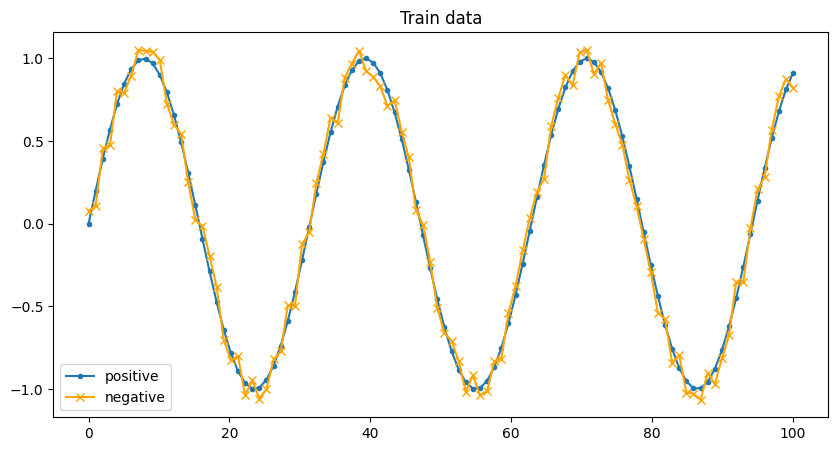

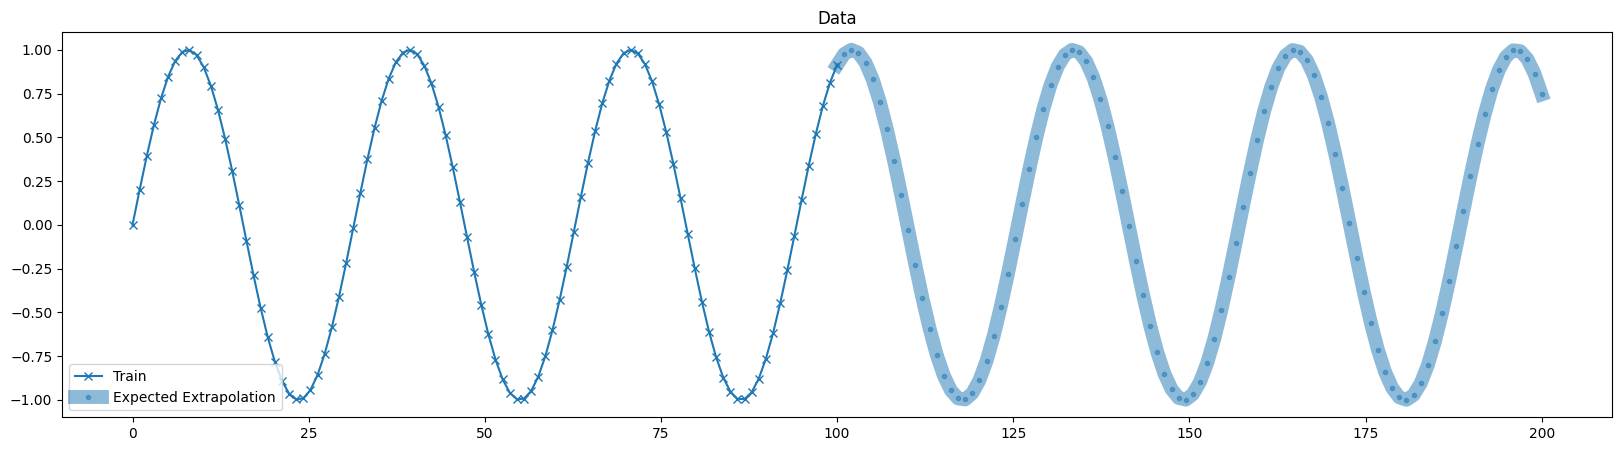

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 354.77it/s]
<ipython-input-25-836e78ce95bd>:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_tr = np.sqrt(((y_pred_tr[plot_i]-y_tr[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te = np.sqrt(((y_pred_te[plot_i]-y_te[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te_avg = np.sqrt(((y_pred_te-y_te)**2).mean()).item() # error measure


eval_mse: tr= 0.08994360268115997
eval_mse: te= 0.6081894636154175
eval_mse avg: te avg= 0.4368811249732971
-----------------MFAN----------------------


<ipython-input-115-bbfb01d80855>:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse.append(np.sqrt(((y_pred_tr-y_tr_eval)**2).mean()).item()) # error measure
<ipython-input-115-bbfb01d80855>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te.append(np.sqrt(((y_pred_te[plot_i]-y_te_eval[plot_i])**2).mean()).item()) # error measure


eval_mse: tr= [1.8057024478912354, 0.31440508365631104, 0.36025470495224, 0.366938978433609, 0.37215209007263184, 0.3734048902988434]
eval_mse: te= [13.081515312194824, 0.852403461933136, 0.19669820368289948, 0.13318504393100739, 0.13686004281044006, 0.14739462733268738]  L 3 :  0.13318504393100739


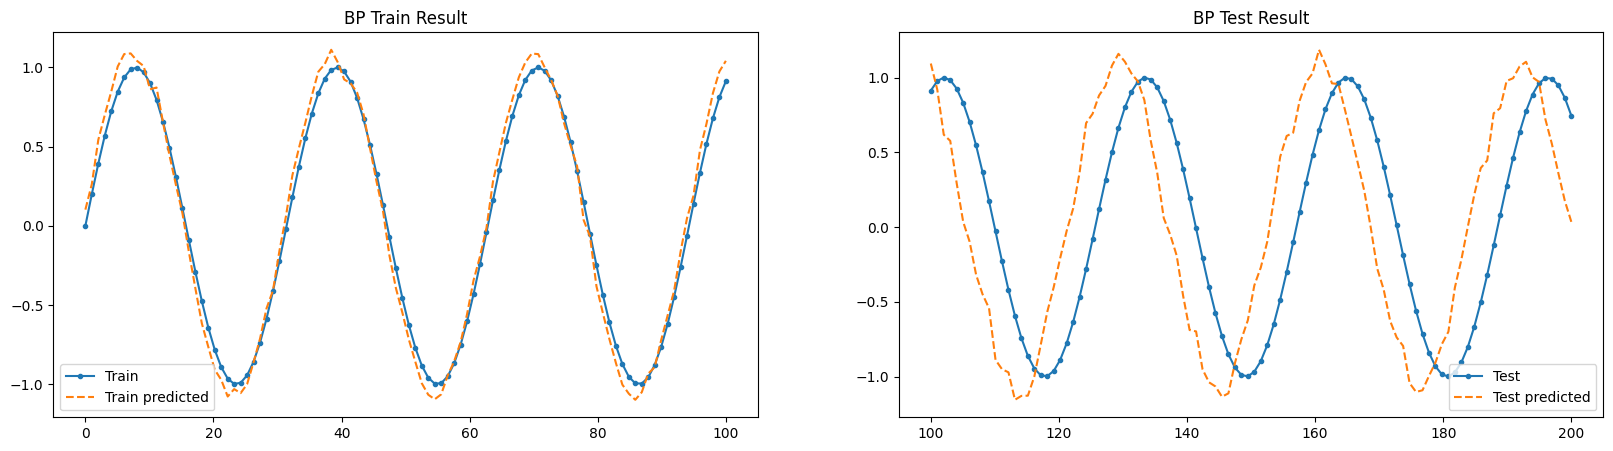

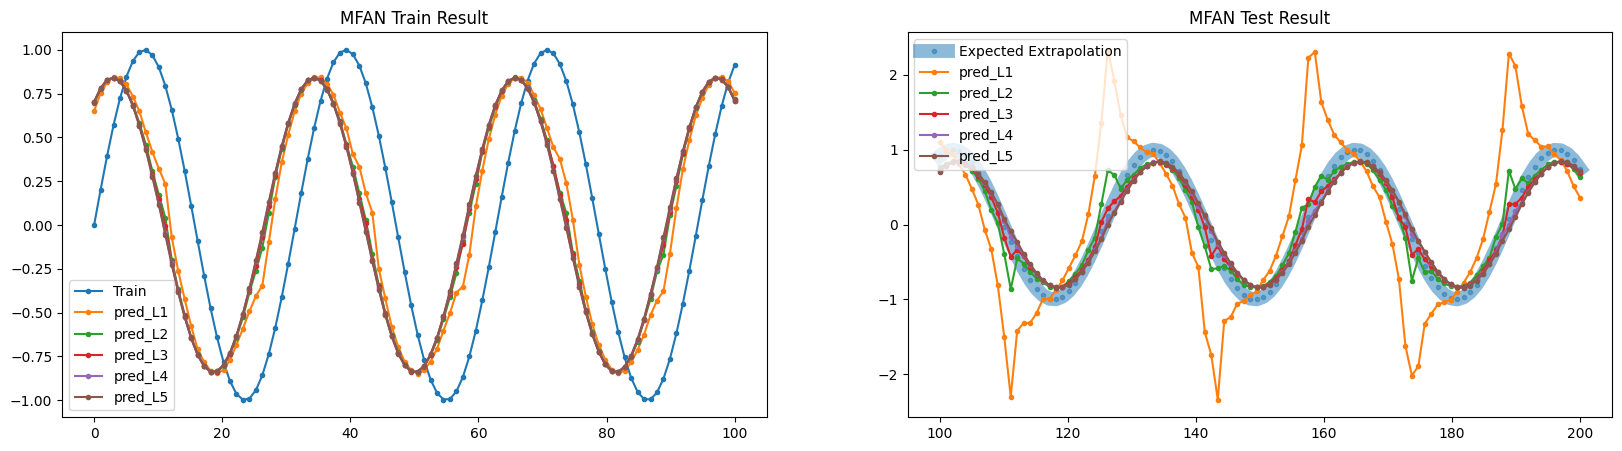

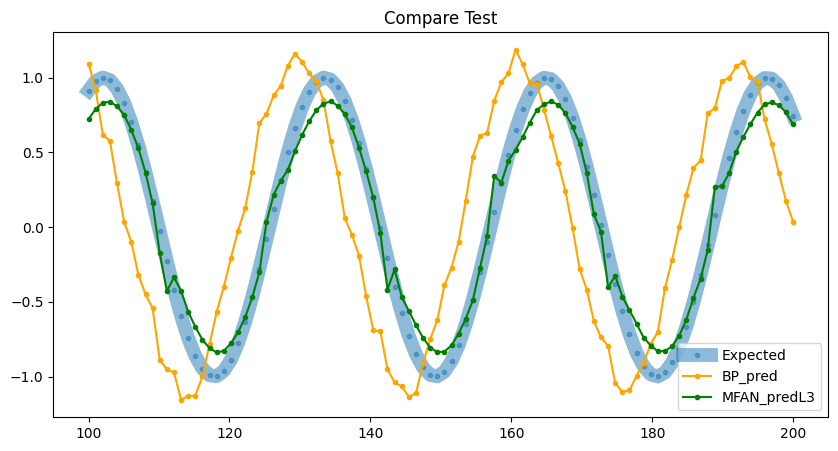

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 346.20it/s]


eval_mse: tr= 0.6142463684082031
eval_mse: te= 0.1513833999633789
eval_mse avg: te avg= 0.7473534345626831
-----------------MFAN----------------------
eval_mse: tr= [2.098090648651123, 0.3251717984676361, 0.36646515130996704, 0.37065163254737854, 0.37328779697418213, 0.37367889285087585]
eval_mse: te= [12.6274995803833, 0.6073706746101379, 0.11765197664499283, 0.13266094028949738, 0.14800889790058136, 0.15253423154354095]  L 3 :  0.13266094028949738


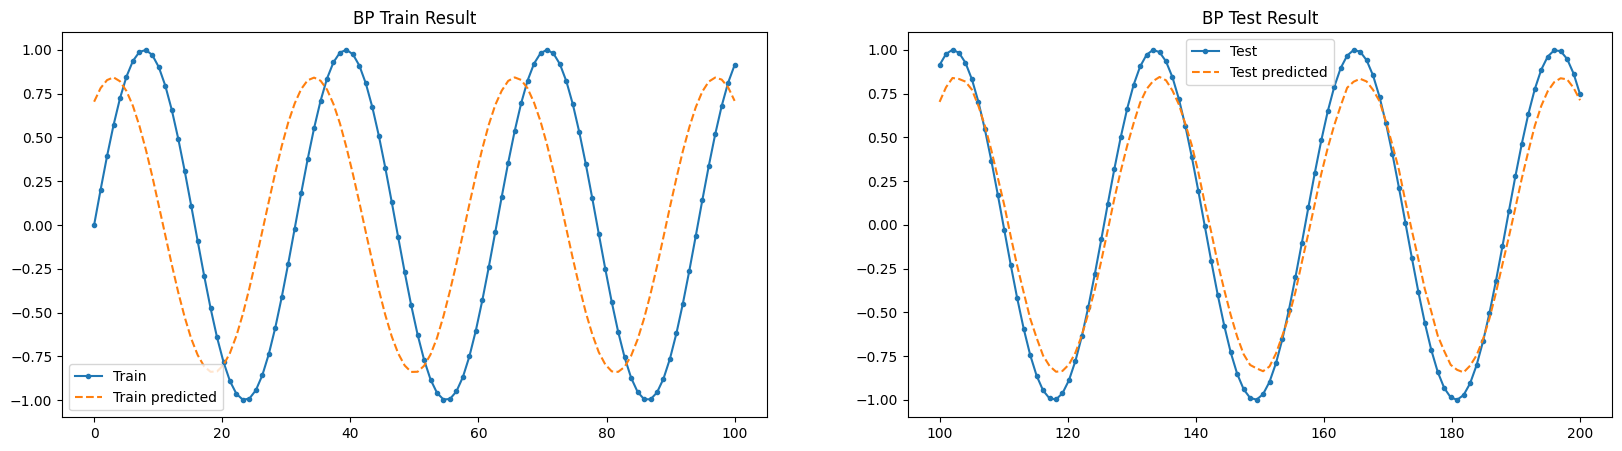

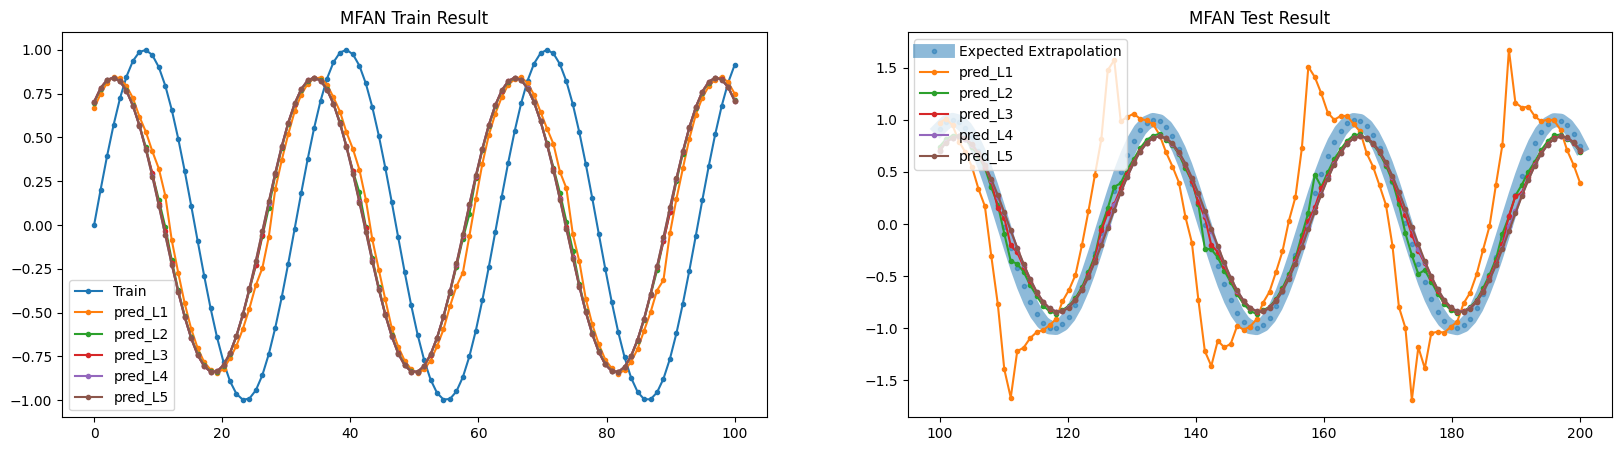

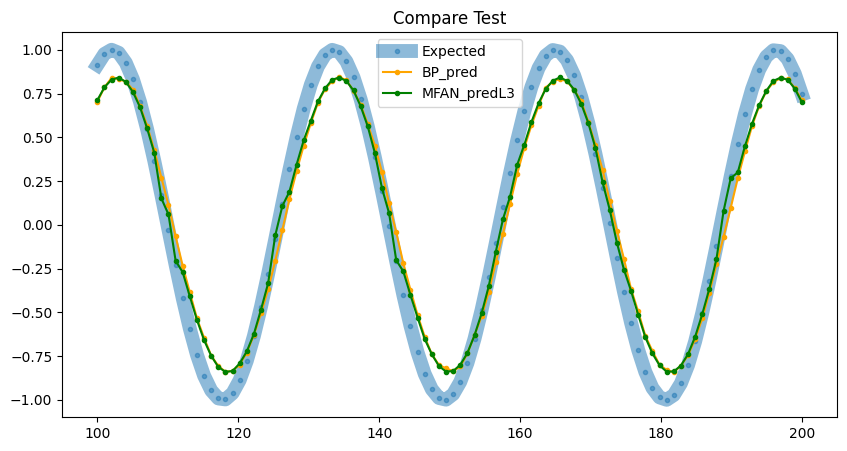

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 312.00it/s]


eval_mse: tr= 0.6144353151321411
eval_mse: te= 0.15251527726650238
eval_mse avg: te avg= 0.7486861348152161
-----------------MFAN----------------------
eval_mse: tr= [1.6783019304275513, 0.33942148089408875, 0.36658260226249695, 0.3695572316646576, 0.37293189764022827, 0.3735658824443817]
eval_mse: te= [12.671640396118164, 0.37664589285850525, 0.13222195208072662, 0.11962393671274185, 0.143635094165802, 0.1509370505809784]  L 3 :  0.11962393671274185


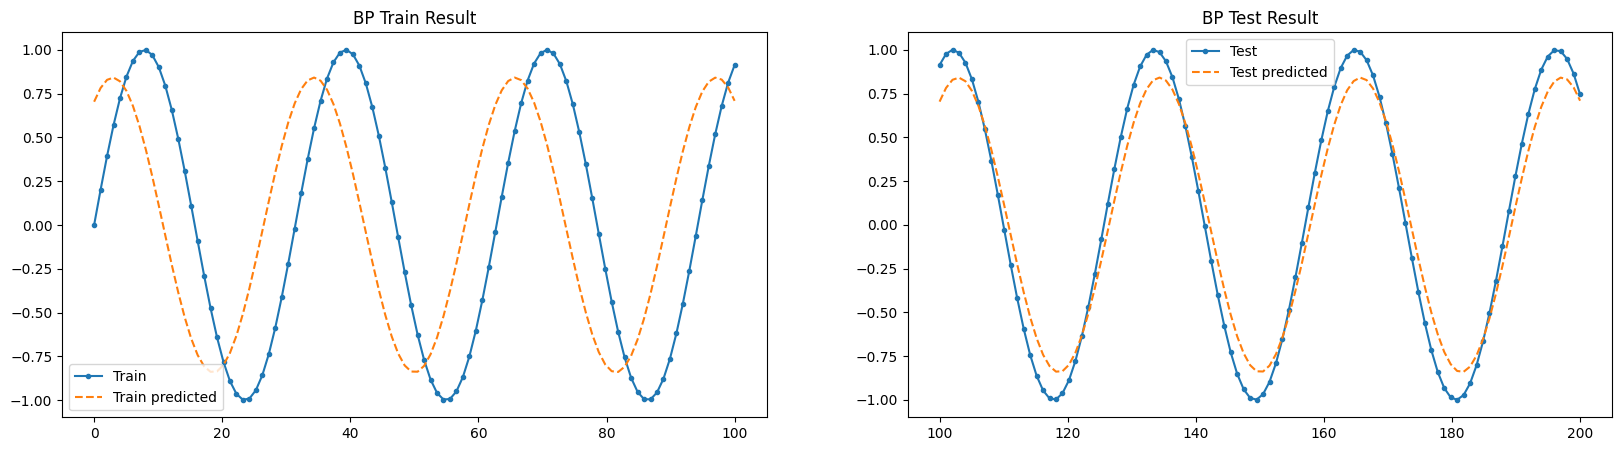

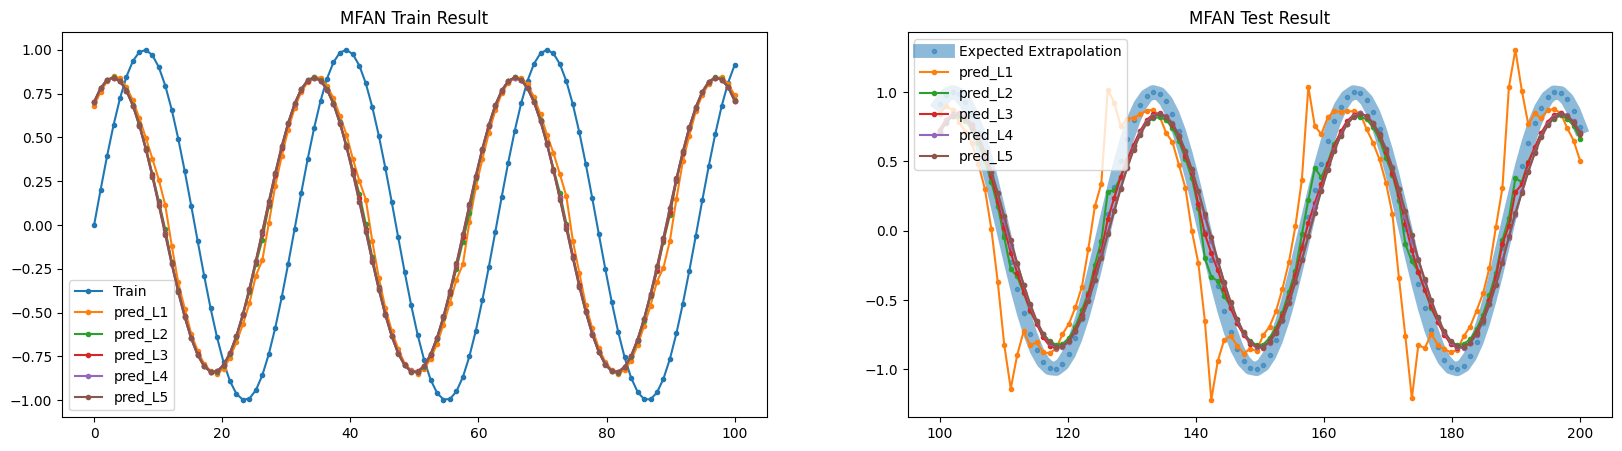

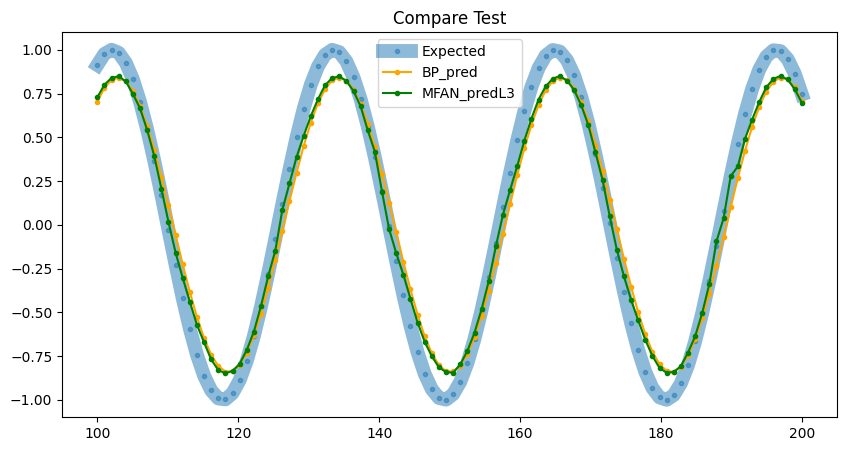

In [ ]:
# Gen
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.sin(0.2*x), do_plot=True)
bpe_L, mfane_L = [], []
for _ in range(3):
    te_err_BP, te_err_MFAN = get_results(mfan_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)
    bpe_L.append(te_err_BP)
    mfane_L.append(te_err_MFAN)

In [ ]:
# Processing collected results
to_rate(bpe_L, mfane_L,
        range=2)

range 2
BP  [30.40947318  7.56917     7.62576386] %
MFAN [6.6592522  6.63304701 5.98119684] %
MFAN better? (BP error rate - MFAN error rate >0?) [23.75022098  0.93612298  1.64456703] %
--------------avg
BP avg 15.201469014088312 %
MFAN avg 6.424498682220777 %
Avg, MFAN better? (>0?) 8.776970331867535 %


## cos

<ipython-input-119-2a4bdef49873>:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f=lambda x: np.cos(0.2*x), do_plot=False)


------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 367.11it/s]
<ipython-input-25-836e78ce95bd>:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_tr = np.sqrt(((y_pred_tr[plot_i]-y_tr[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te = np.sqrt(((y_pred_te[plot_i]-y_te[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te_avg = np.sqrt(((y_pred_te-y_te)**2).mean()).item() # error measure


eval_mse: tr= 0.18490010499954224
eval_mse: te= 0.40016892552375793
eval_mse avg: te avg= 0.47097477316856384
-----------------MFAN----------------------


<ipython-input-115-bbfb01d80855>:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse.append(np.sqrt(((y_pred_tr-y_tr_eval)**2).mean()).item()) # error measure
<ipython-input-115-bbfb01d80855>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te.append(np.sqrt(((y_pred_te[plot_i]-y_te_eval[plot_i])**2).mean()).item()) # error measure


eval_mse: tr= [2.2119369506835938, 0.3490525186061859, 0.38077569007873535, 0.3846234679222107, 0.3874434530735016, 0.38892072439193726]
eval_mse: te= [13.808862686157227, 0.5146842002868652, 0.143330916762352, 0.12238200753927231, 0.13087791204452515, 0.1452658772468567]  L 3 :  0.12238200753927231


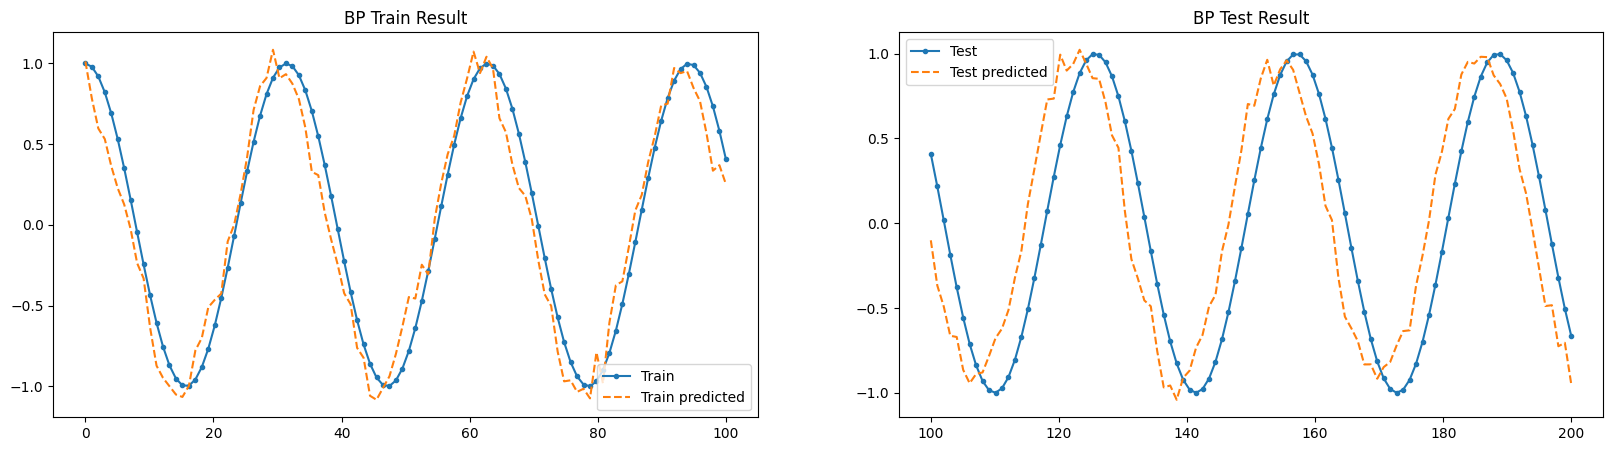

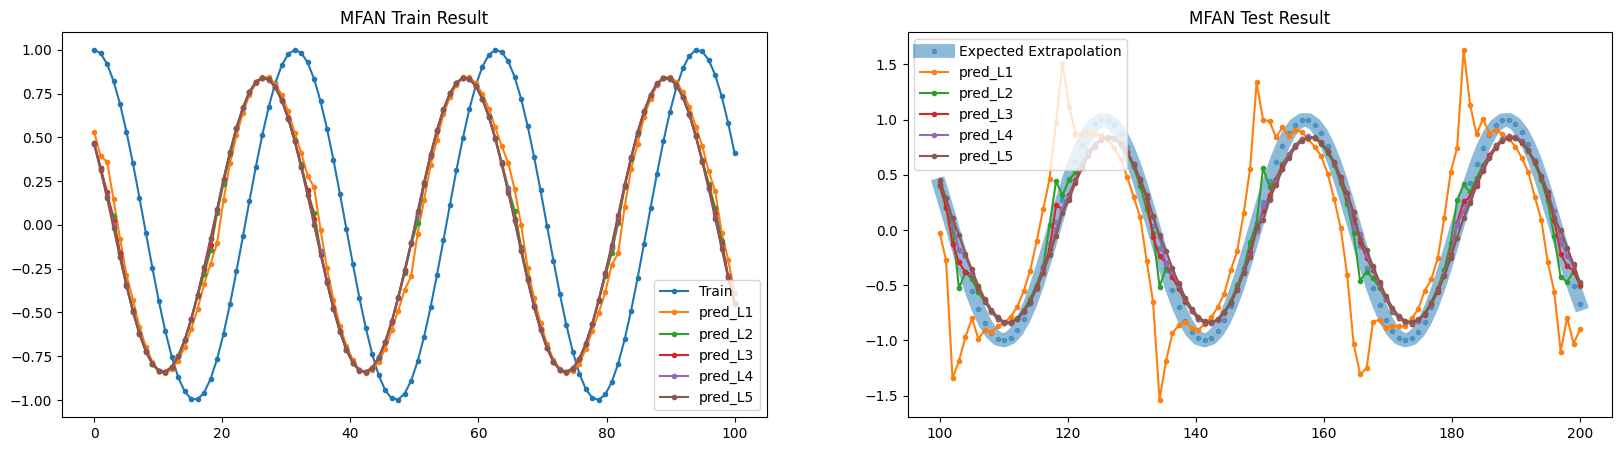

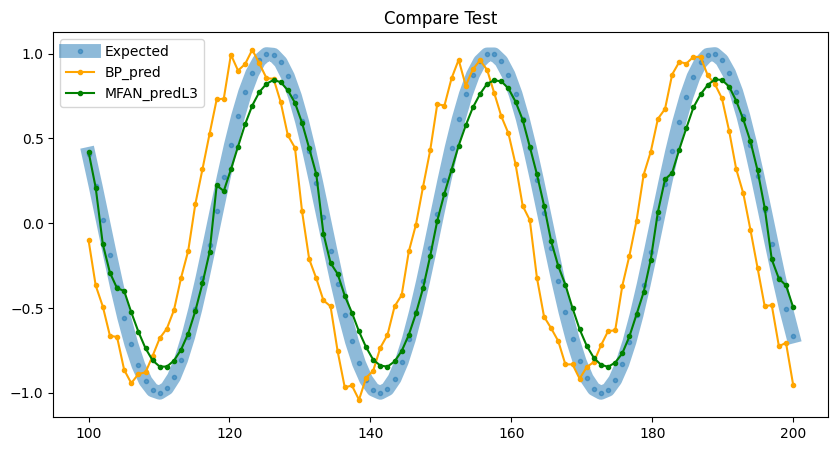

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 356.52it/s]


eval_mse: tr= 0.05665970593690872
eval_mse: te= 0.621239960193634
eval_mse avg: te avg= 0.40636318922042847
-----------------MFAN----------------------
eval_mse: tr= [1.5779844522476196, 0.33825111389160156, 0.38221171498298645, 0.3861996531486511, 0.3894566297531128, 0.3896635174751282]
eval_mse: te= [13.26088809967041, 0.6523565053939819, 0.12112444639205933, 0.1251695454120636, 0.14781342446804047, 0.15048348903656006]  L 3 :  0.1251695454120636


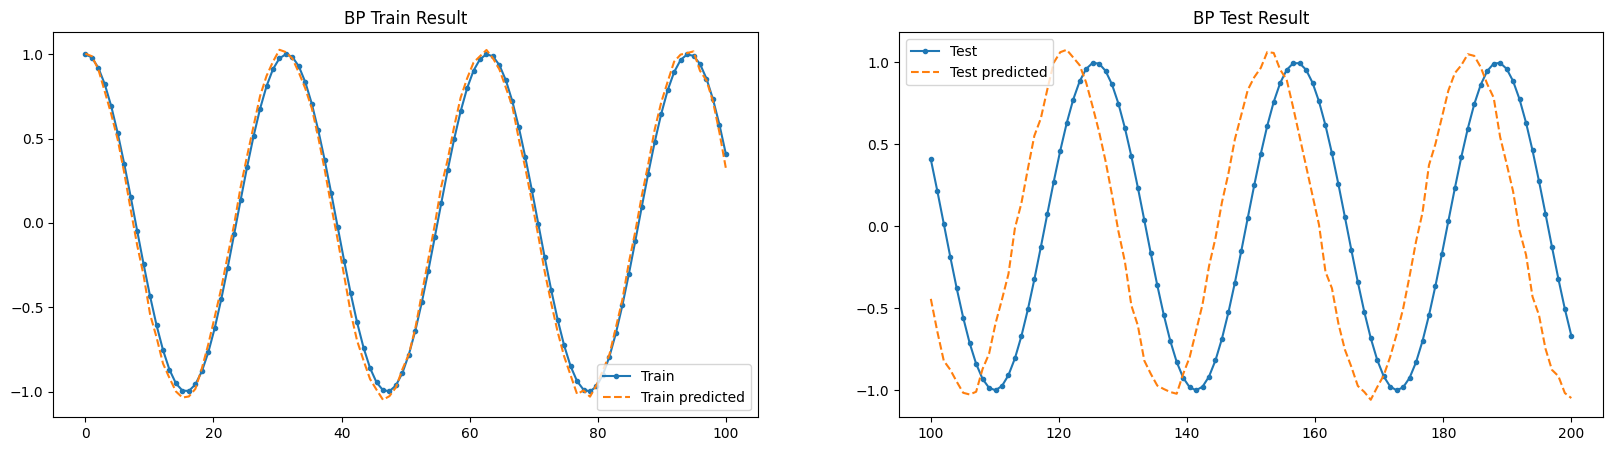

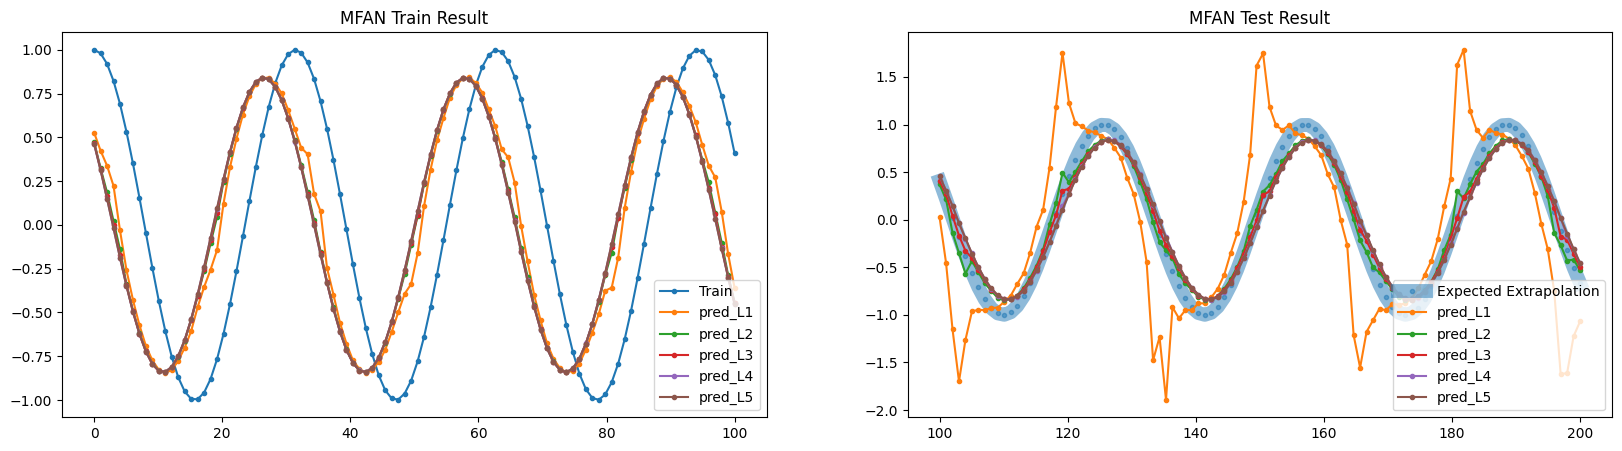

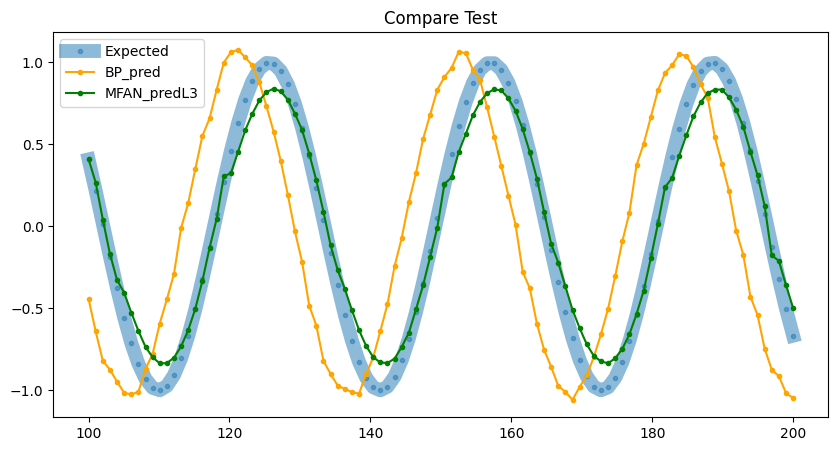

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 233.09it/s]


eval_mse: tr= 0.6174510717391968
eval_mse: te= 0.590813398361206
eval_mse avg: te avg= 0.4221150279045105
-----------------MFAN----------------------
eval_mse: tr= [1.2470388412475586, 0.33438625931739807, 0.38127097487449646, 0.3856833577156067, 0.38930296897888184, 0.3896462917327881]
eval_mse: te= [12.460785865783691, 0.702139139175415, 0.1435908079147339, 0.12274619191884995, 0.14705780148506165, 0.14944548904895782]  L 3 :  0.12274619191884995


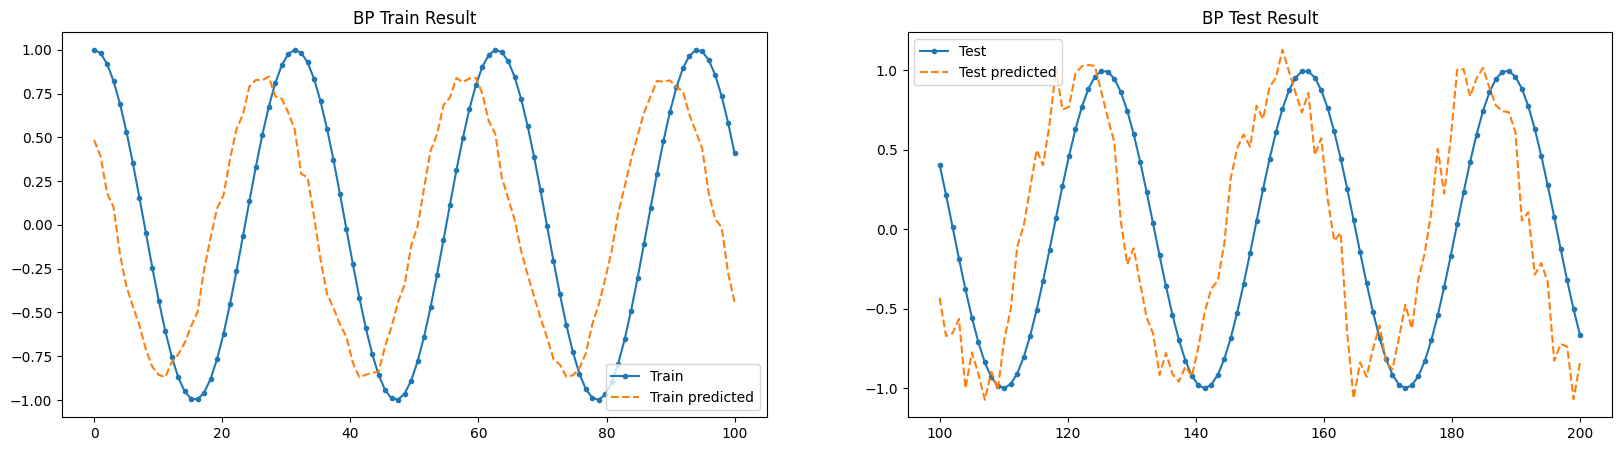

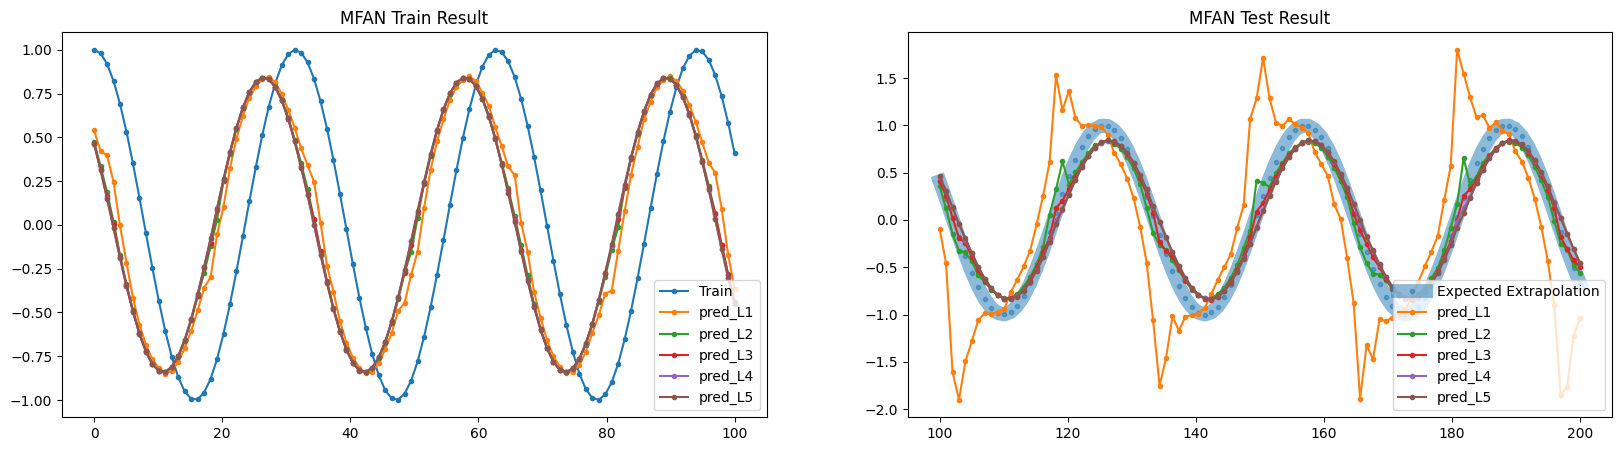

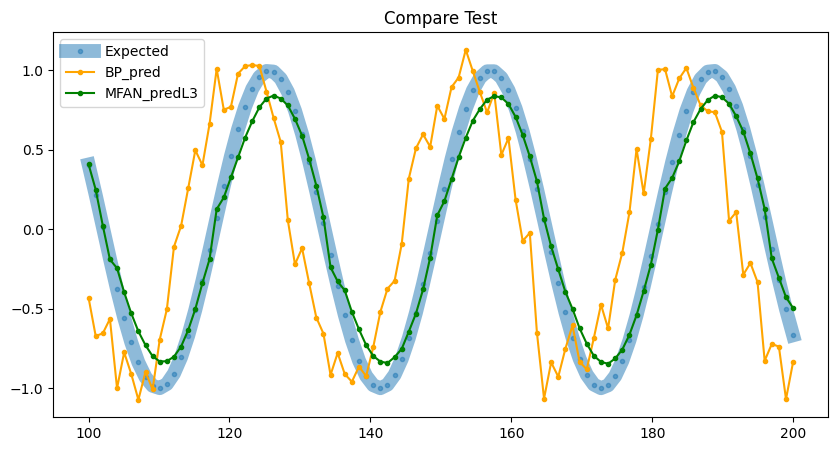

In [ ]:
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.cos(0.2*x), do_plot=False)
bpe_L, mfane_L = [], []
for _ in range(3):
    te_err_BP, te_err_MFAN = get_results(mfan_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)
    bpe_L.append(te_err_BP)
    mfane_L.append(te_err_MFAN)

In [ ]:
to_rate(bpe_L, mfane_L,
        range=2)

range 2
BP  [20.00844628 31.06199801 29.54066992] %
MFAN [6.11910038 6.25847727 6.1373096 ] %
MFAN better? (BP error rate - MFAN error rate >0?) [13.8893459  24.80352074 23.40336032] %
--------------avg
BP avg 26.870371401309967 %
MFAN avg 6.1716290811697645 %
Avg, MFAN better? (>0?) 20.6987423201402 %


## sin cos

<ipython-input-129-11568a861ad9>:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f=lambda x: np.sin(0.4*np.cos(0.2*x)), do_plot=False)


------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 341.21it/s]
<ipython-input-25-836e78ce95bd>:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_tr = np.sqrt(((y_pred_tr[plot_i]-y_tr[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te = np.sqrt(((y_pred_te[plot_i]-y_te[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te_avg = np.sqrt(((y_pred_te-y_te)**2).mean()).item() # error measure


eval_mse: tr= 0.25019195675849915
eval_mse: te= 0.0600588321685791
eval_mse avg: te avg= 0.29577893018722534
-----------------MFAN----------------------


<ipython-input-115-bbfb01d80855>:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse.append(np.sqrt(((y_pred_tr-y_tr_eval)**2).mean()).item()) # error measure
<ipython-input-115-bbfb01d80855>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te.append(np.sqrt(((y_pred_te[plot_i]-y_te_eval[plot_i])**2).mean()).item()) # error measure


eval_mse: tr= [1.3604674339294434, 0.10806701332330704, 0.14497460424900055, 0.1484372317790985, 0.1523323804140091, 0.15268568694591522]
eval_mse: te= [5.495676517486572, 0.575859546661377, 0.09814462810754776, 0.05168098583817482, 0.052497148513793945, 0.05675783008337021]  L 3 :  0.05168098583817482


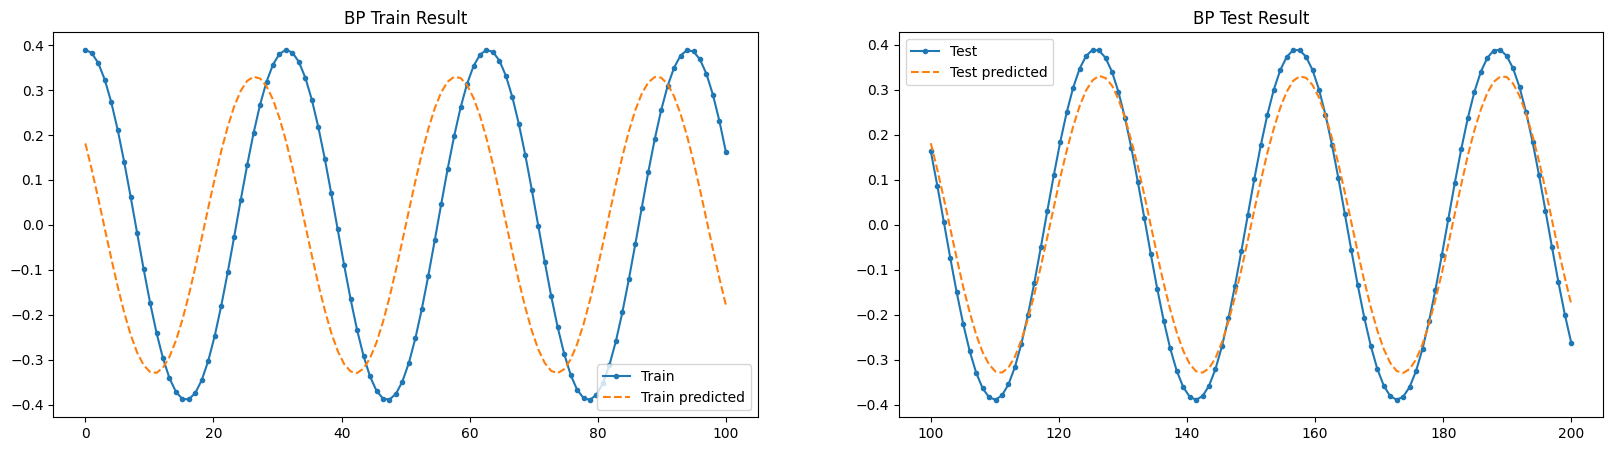

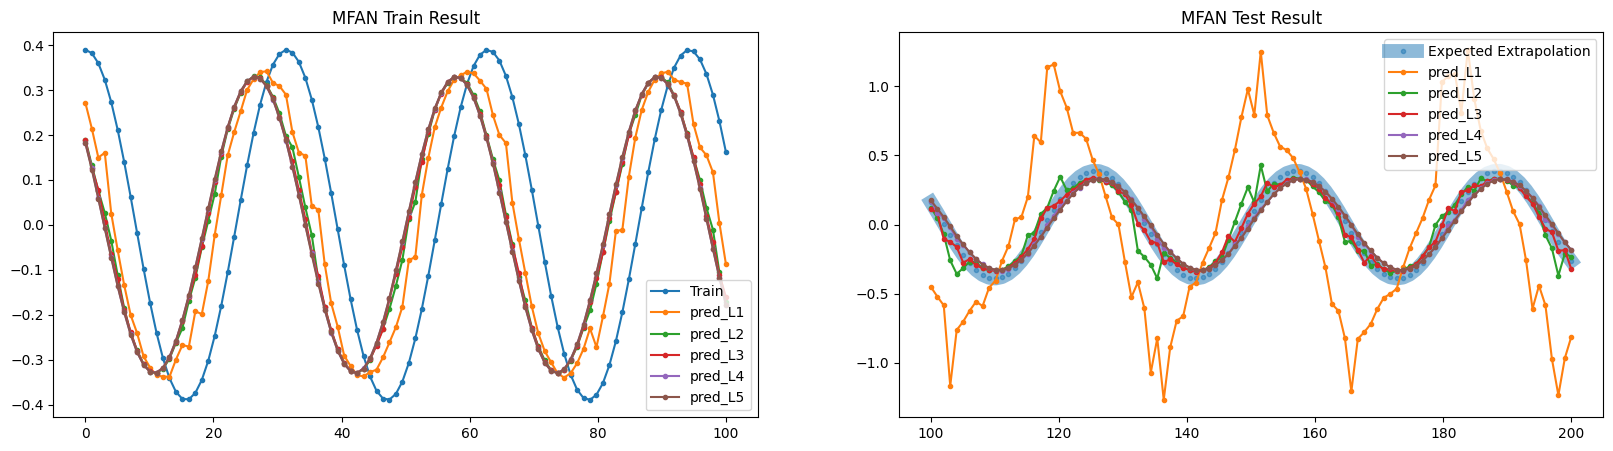

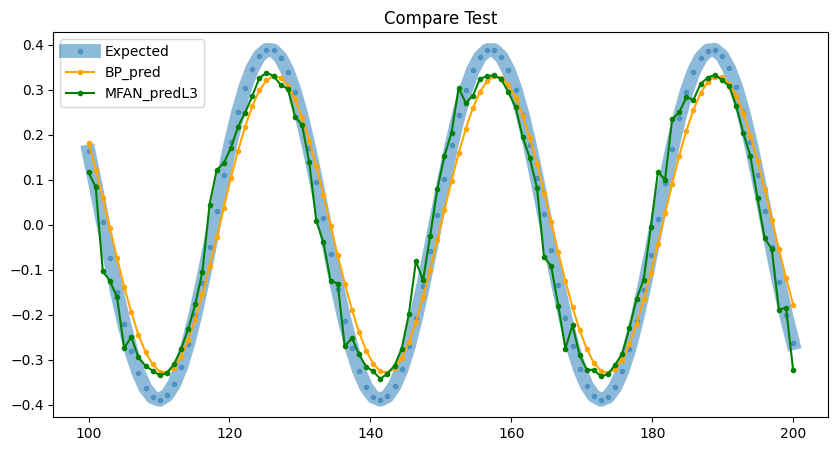

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 349.15it/s]


eval_mse: tr= 0.06496681272983551
eval_mse: te= 0.30292949080467224
eval_mse avg: te avg= 0.20788758993148804
-----------------MFAN----------------------
eval_mse: tr= [2.121371030807495, 0.12169023603200912, 0.1443355679512024, 0.1491183340549469, 0.15257711708545685, 0.15285509824752808]
eval_mse: te= [6.620750427246094, 0.3683798611164093, 0.08727238327264786, 0.04328472539782524, 0.05619806796312332, 0.059884022921323776]  L 3 :  0.04328472539782524


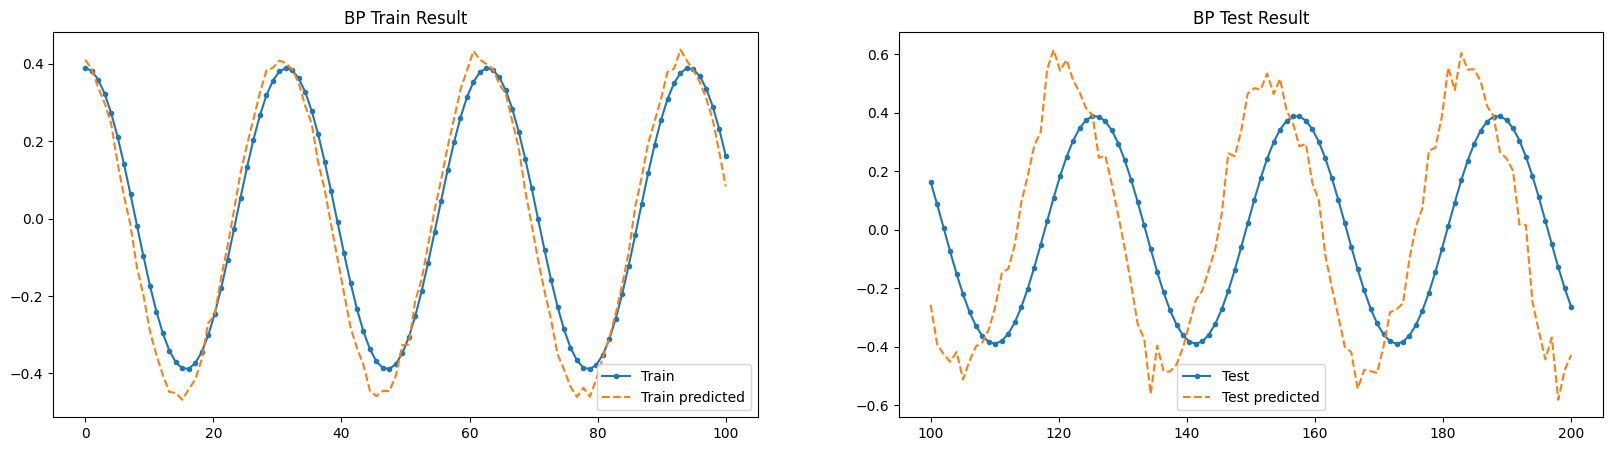

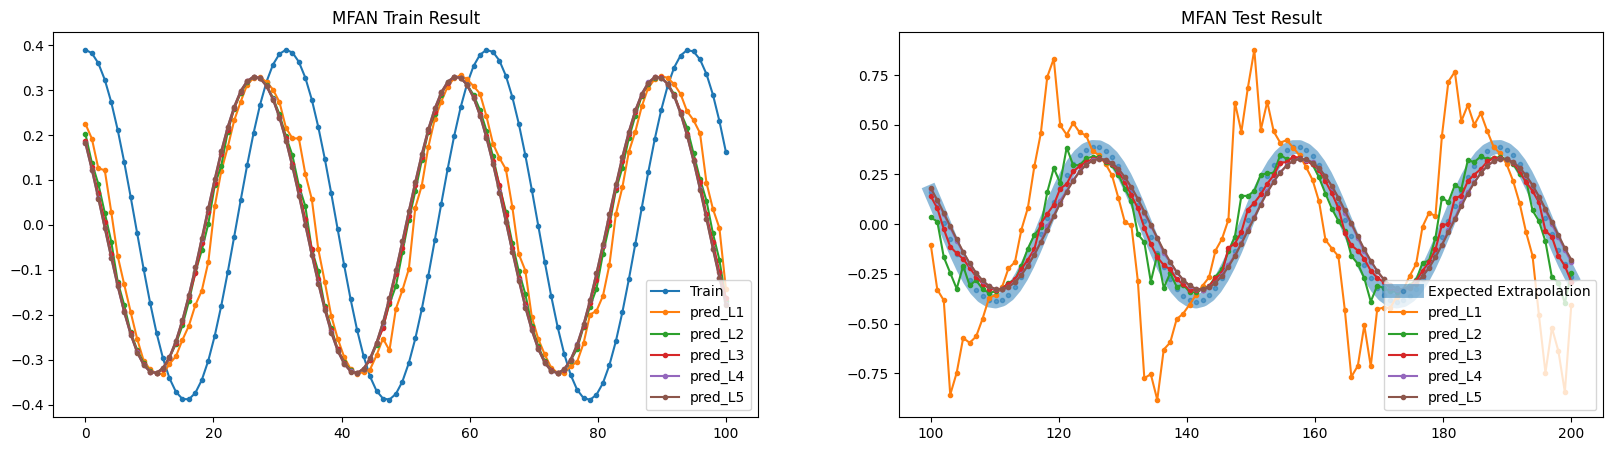

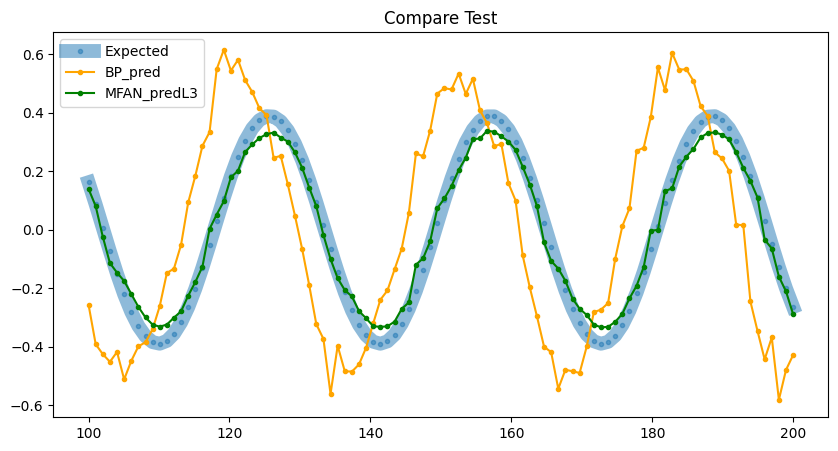

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 284.26it/s]


eval_mse: tr= 0.04431431367993355
eval_mse: te= 0.334479957818985
eval_mse avg: te avg= 0.22462347149848938
-----------------MFAN----------------------
eval_mse: tr= [1.236997365951538, 0.08833435922861099, 0.13847115635871887, 0.14807501435279846, 0.15181927382946014, 0.15273509919643402]
eval_mse: te= [5.503591537475586, 0.7963903546333313, 0.1432727724313736, 0.051596030592918396, 0.04852772504091263, 0.057239070534706116]  L 3 :  0.051596030592918396


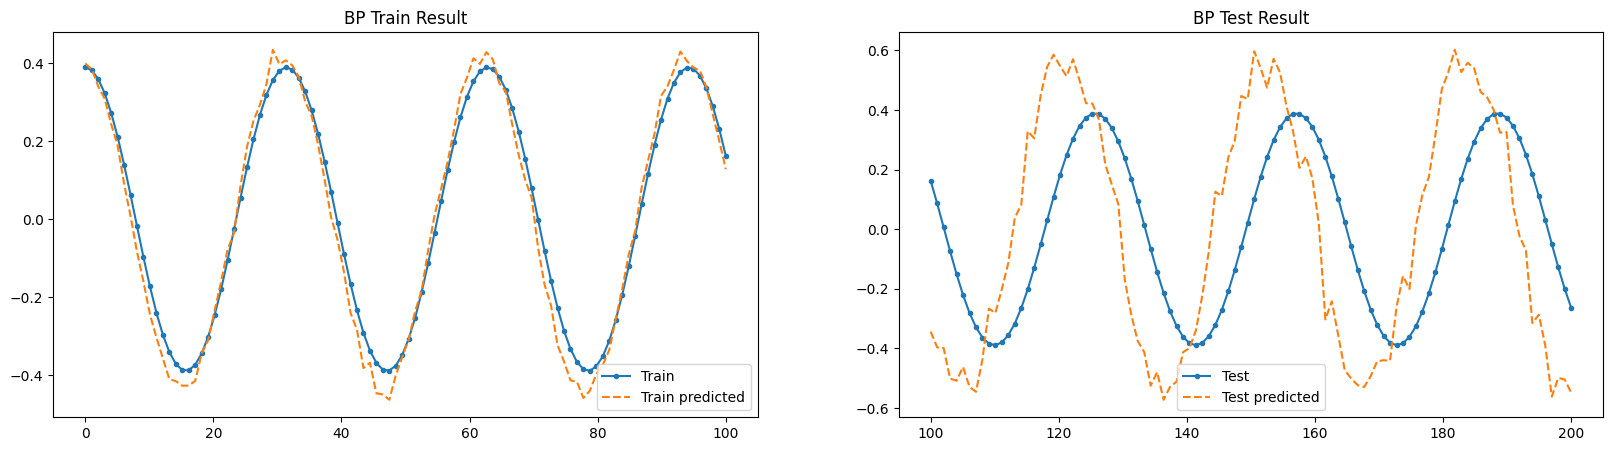

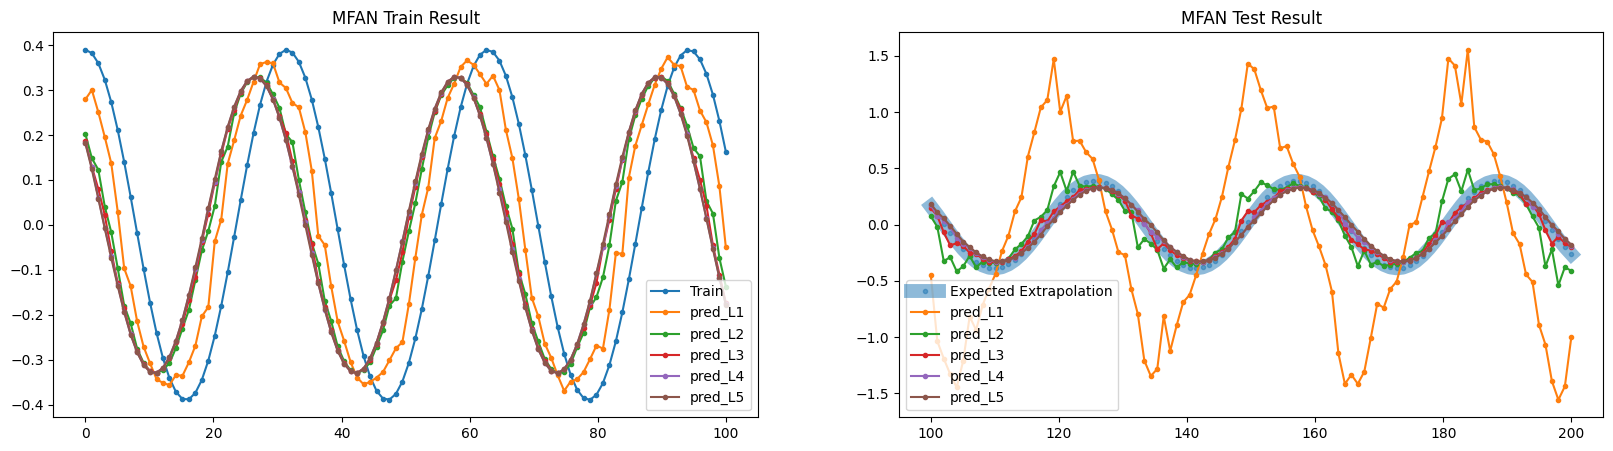

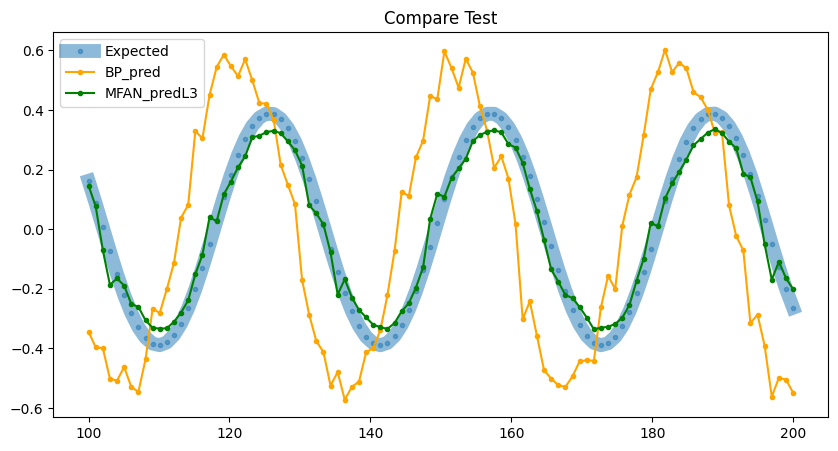

In [ ]:
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.sin(0.4*np.cos(0.2*x)), do_plot=False)
bpe_L, mfane_L = [], []
for _ in range(3):
    te_err_BP, te_err_MFAN = get_results(mfan_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)
    bpe_L.append(te_err_BP)
    mfane_L.append(te_err_MFAN)

In [ ]:
to_rate(bpe_L, mfane_L,
        range=0.8)

range 0.8
BP  [ 7.50735402 37.86618635 41.80999473] %
MFAN [6.46012323 5.41059067 6.44950382] %
MFAN better? (BP error rate - MFAN error rate >0?) [ 1.04723079 32.45559568 35.3604909 ] %
--------------avg
BP avg 29.06117836634318 %
MFAN avg 6.106739242871602 %
Avg, MFAN better? (>0?) 22.95443912347158 %


## sin cos c

<ipython-input-123-d4da3f09910c>:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f=lambda x: np.sin(0.4*np.cos(0.2*x)+30), do_plot=False)


------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 330.23it/s]
<ipython-input-25-836e78ce95bd>:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_tr = np.sqrt(((y_pred_tr[plot_i]-y_tr[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te = np.sqrt(((y_pred_te[plot_i]-y_te[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te_avg = np.sqrt(((y_pred_te-y_te)**2).mean()).item() # error measure


eval_mse: tr= 0.05142877250909805
eval_mse: te= 0.044627074152231216
eval_mse avg: te avg= 0.0781746655702591
-----------------MFAN----------------------


<ipython-input-115-bbfb01d80855>:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse.append(np.sqrt(((y_pred_tr-y_tr_eval)**2).mean()).item()) # error measure
<ipython-input-115-bbfb01d80855>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te.append(np.sqrt(((y_pred_te[plot_i]-y_te_eval[plot_i])**2).mean()).item()) # error measure


eval_mse: tr= [0.8449362516403198, 0.021490510553121567, 0.03028538078069687, 0.0325213186442852, 0.033853087574243546, 0.033990196883678436]
eval_mse: te= [2.3652918338775635, 0.16719484329223633, 0.04538669437170029, 0.01751224510371685, 0.01829179748892784, 0.018907582387328148]  L 3 :  0.01751224510371685


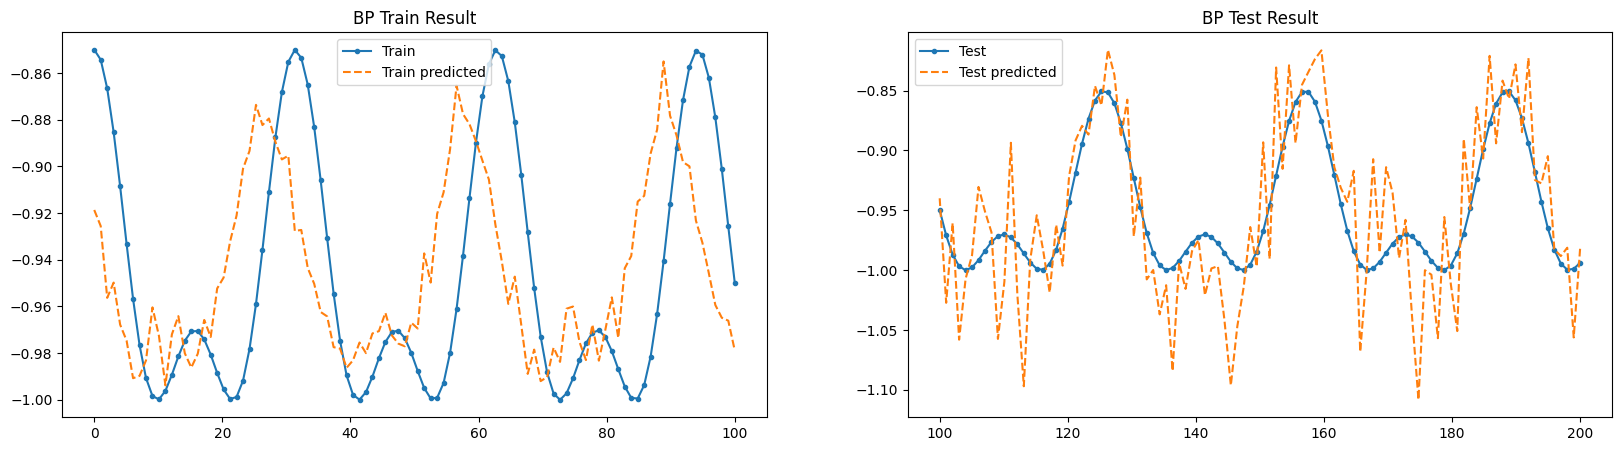

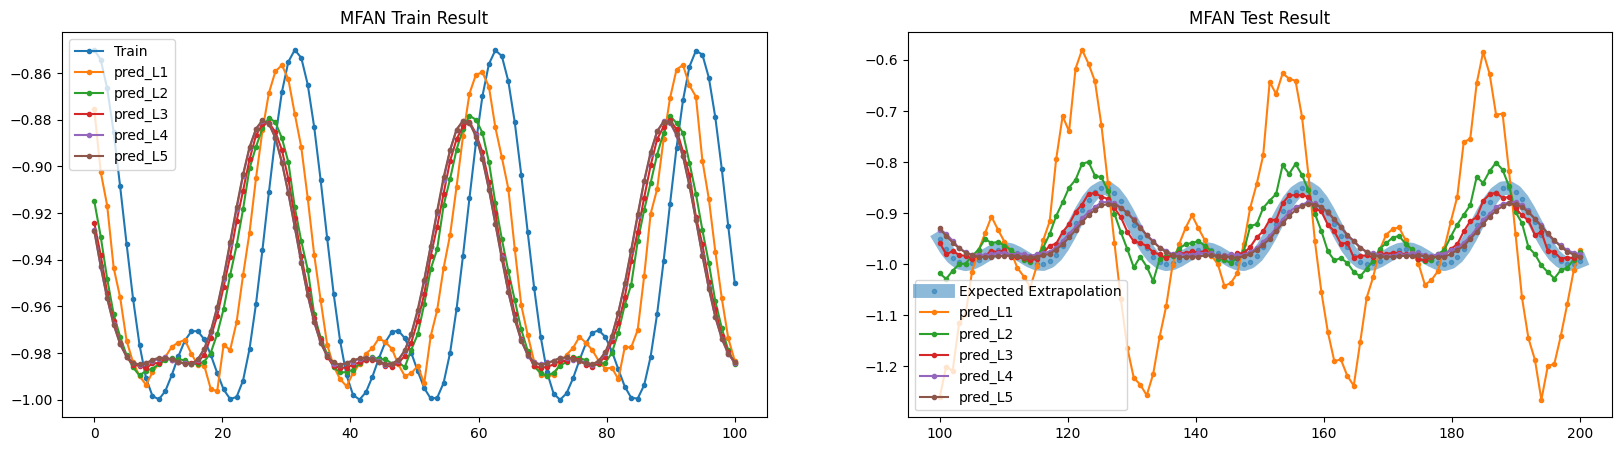

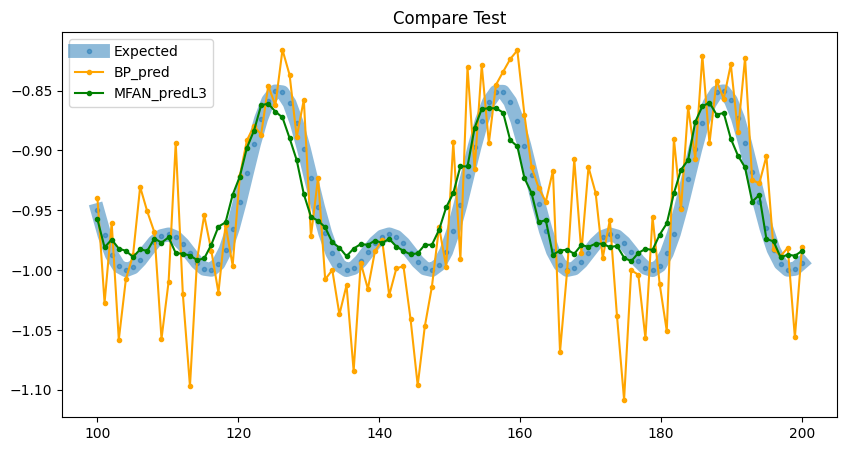

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 342.76it/s]


eval_mse: tr= 0.04123967885971069
eval_mse: te= 0.024052411317825317
eval_mse avg: te avg= 0.051813047379255295
-----------------MFAN----------------------
eval_mse: tr= [1.3275260925292969, 0.025113465264439583, 0.03207270801067352, 0.03353677690029144, 0.034009020775556564, 0.033994410187006]
eval_mse: te= [3.2637932300567627, 0.1310473382472992, 0.029344268143177032, 0.016826903447508812, 0.020441407337784767, 0.0188987348228693]  L 3 :  0.016826903447508812


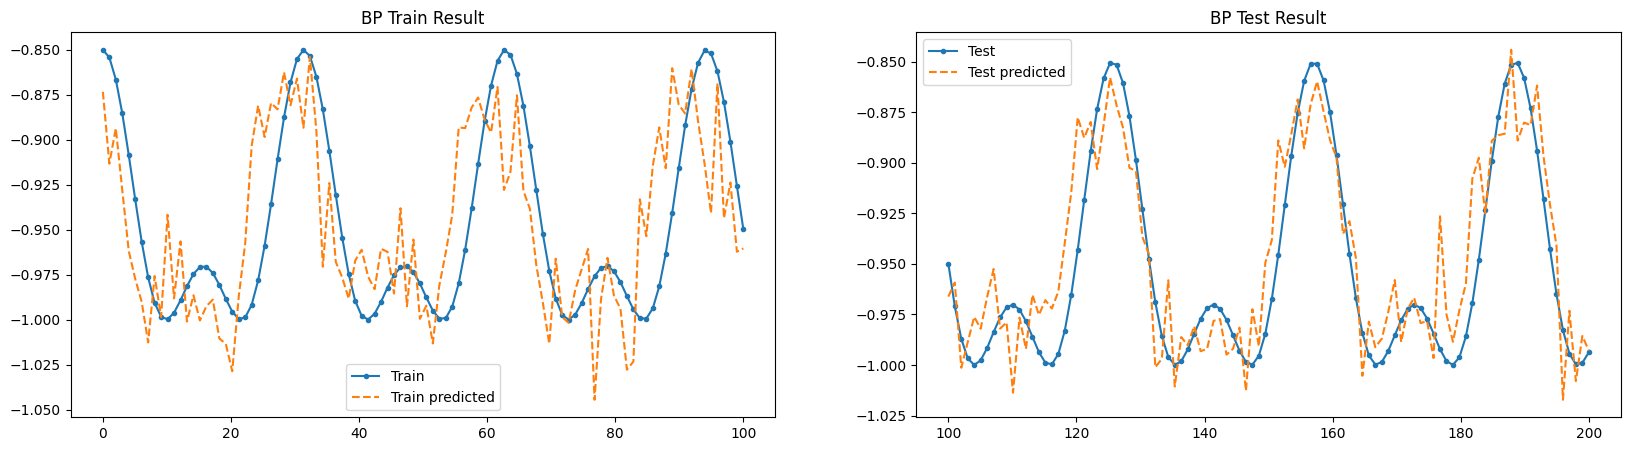

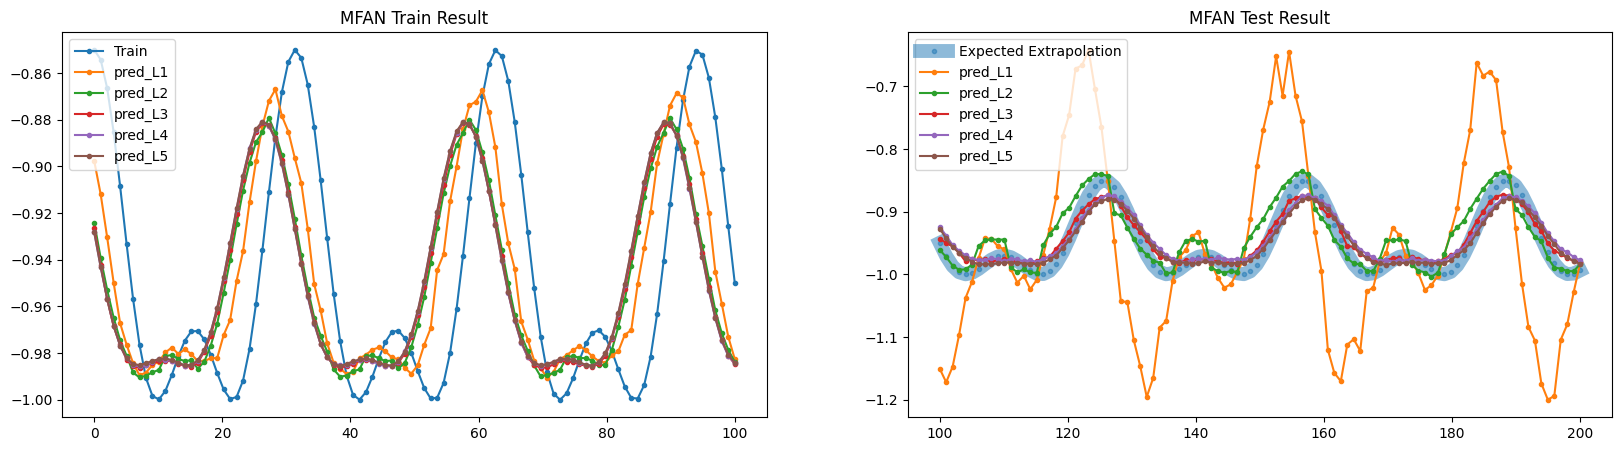

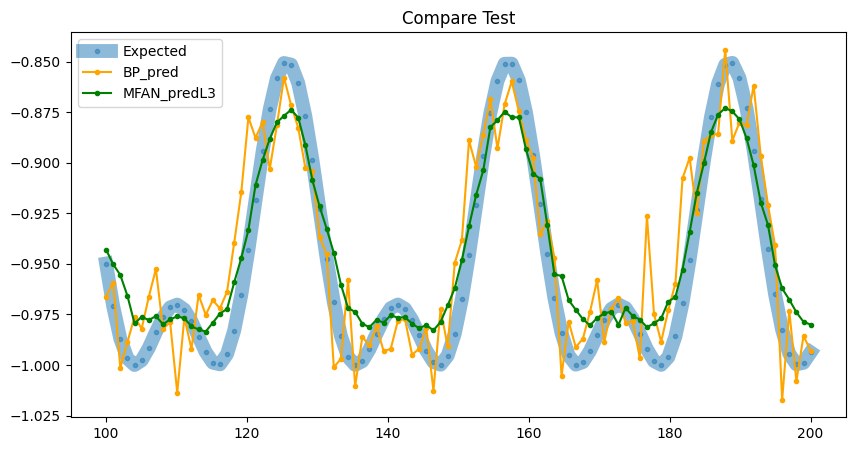

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 237.74it/s]


eval_mse: tr= 0.05394500866532326
eval_mse: te= 0.018751803785562515
eval_mse avg: te avg= 0.05587945133447647
-----------------MFAN----------------------
eval_mse: tr= [1.7692017555236816, 0.022985726594924927, 0.03224220871925354, 0.03285881504416466, 0.0339331179857254, 0.03400237485766411]
eval_mse: te= [4.268488883972168, 0.1258411705493927, 0.018847990781068802, 0.015141166746616364, 0.019272129982709885, 0.01884138584136963]  L 3 :  0.015141166746616364


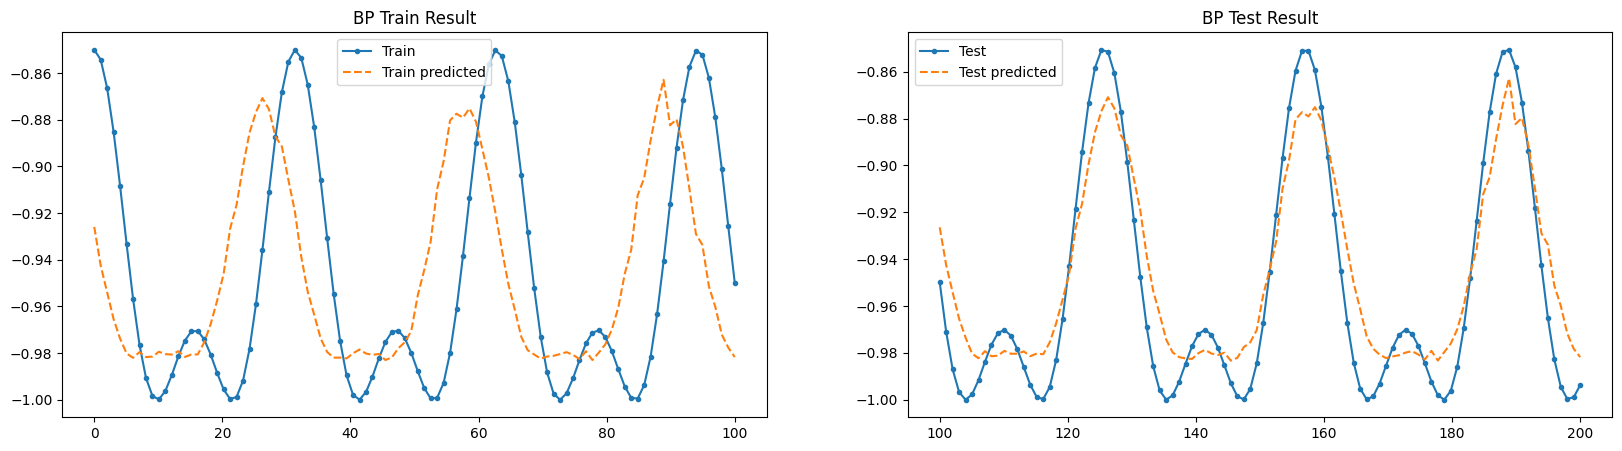

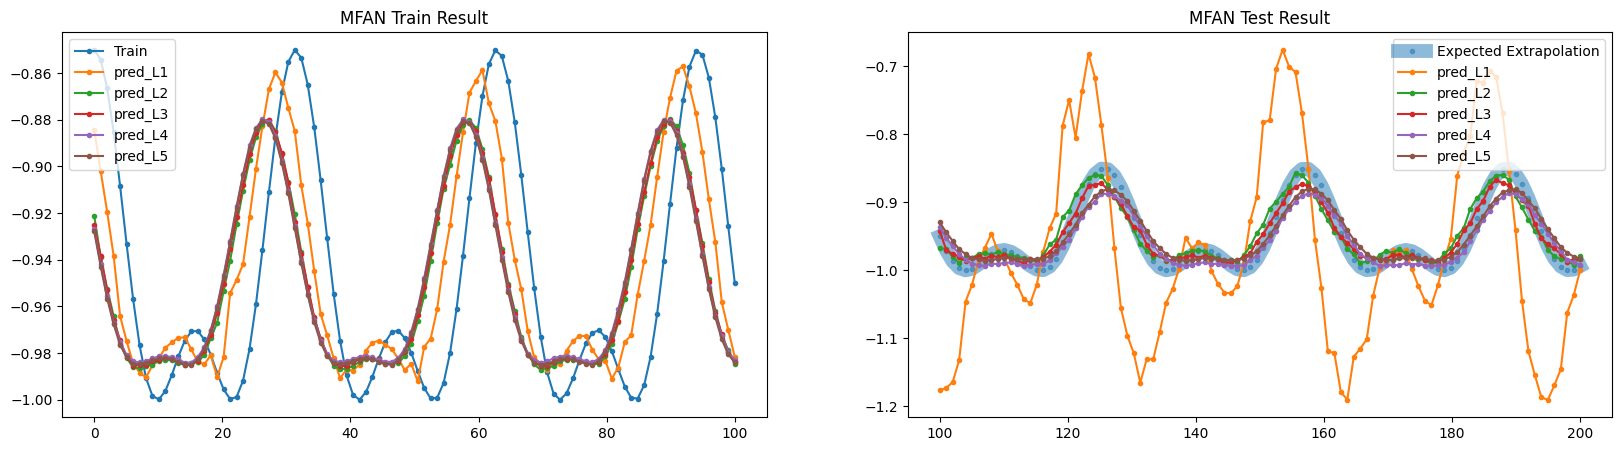

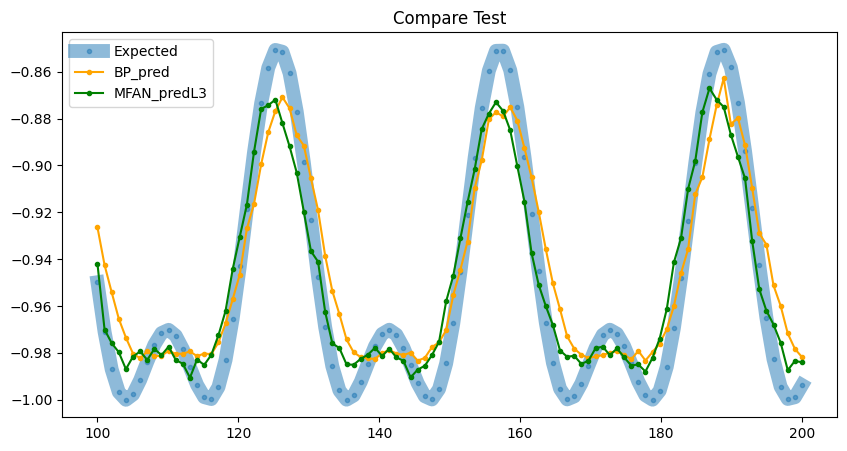

In [ ]:
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.sin(0.4*np.cos(0.2*x)+30), do_plot=False)
bpe_L, mfane_L = [], []
for _ in range(3):
    te_err_BP, te_err_MFAN = get_results(mfan_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)
    bpe_L.append(te_err_BP)
    mfane_L.append(te_err_MFAN)

In [ ]:
to_rate(bpe_L, mfane_L,
        range=0.15)

range 0.15
BP  [29.75138277 16.03494088 12.50120252] %
MFAN [11.67483007 11.21793563 10.09411116] %
MFAN better? (BP error rate - MFAN error rate >0?) [18.0765527   4.81700525  2.40709136] %
--------------avg
BP avg 19.42917539013757 %
MFAN avg 10.995625621742674 %
Avg, MFAN better? (>0?) 8.433549768394895 %


## sin a cos c

<ipython-input-125-8d078b999306>:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f=lambda x: np.sin(0.8*np.cos(0.2*x)+20), do_plot=False)


------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 343.58it/s]
<ipython-input-25-836e78ce95bd>:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_tr = np.sqrt(((y_pred_tr[plot_i]-y_tr[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te = np.sqrt(((y_pred_te[plot_i]-y_te[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te_avg = np.sqrt(((y_pred_te-y_te)**2).mean()).item() # error measure


eval_mse: tr= 0.1280210316181183
eval_mse: te= 0.2710742950439453
eval_mse avg: te avg= 0.23618291318416595
-----------------MFAN----------------------


<ipython-input-115-bbfb01d80855>:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse.append(np.sqrt(((y_pred_tr-y_tr_eval)**2).mean()).item()) # error measure
<ipython-input-115-bbfb01d80855>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te.append(np.sqrt(((y_pred_te[plot_i]-y_te_eval[plot_i])**2).mean()).item()) # error measure


eval_mse: tr= [1.9956443309783936, 0.12439882755279541, 0.143568754196167, 0.14537423849105835, 0.1459590494632721, 0.14627446234226227]
eval_mse: te= [6.379966735839844, 0.2826249301433563, 0.06449160724878311, 0.06487156450748444, 0.06953496485948563, 0.07078395038843155]  L 3 :  0.06487156450748444


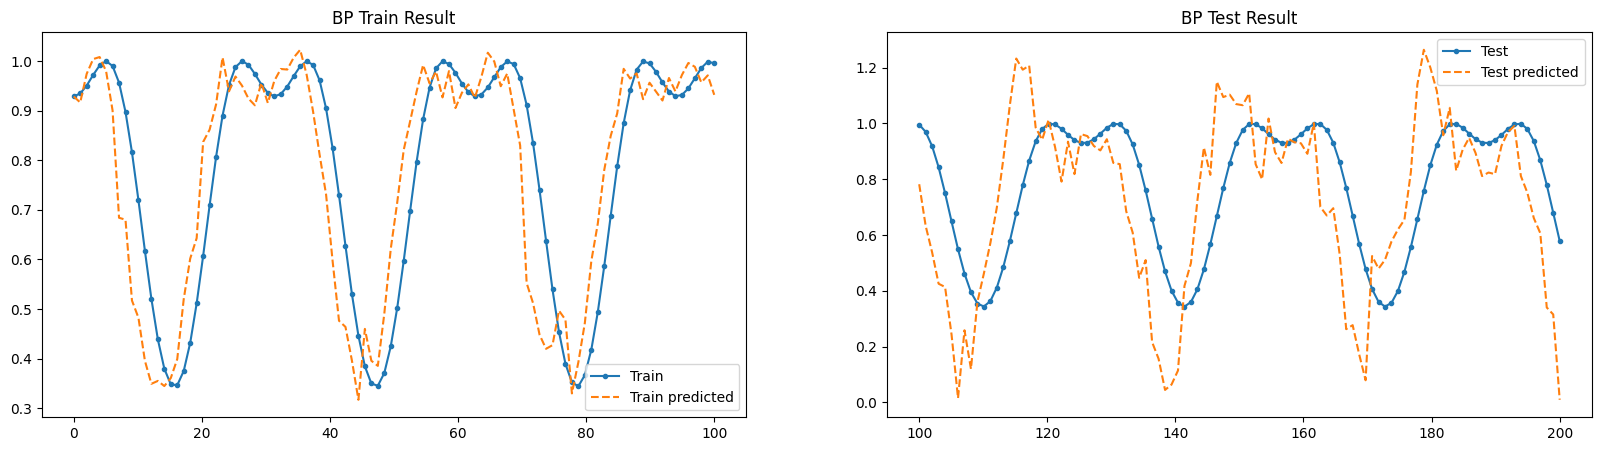

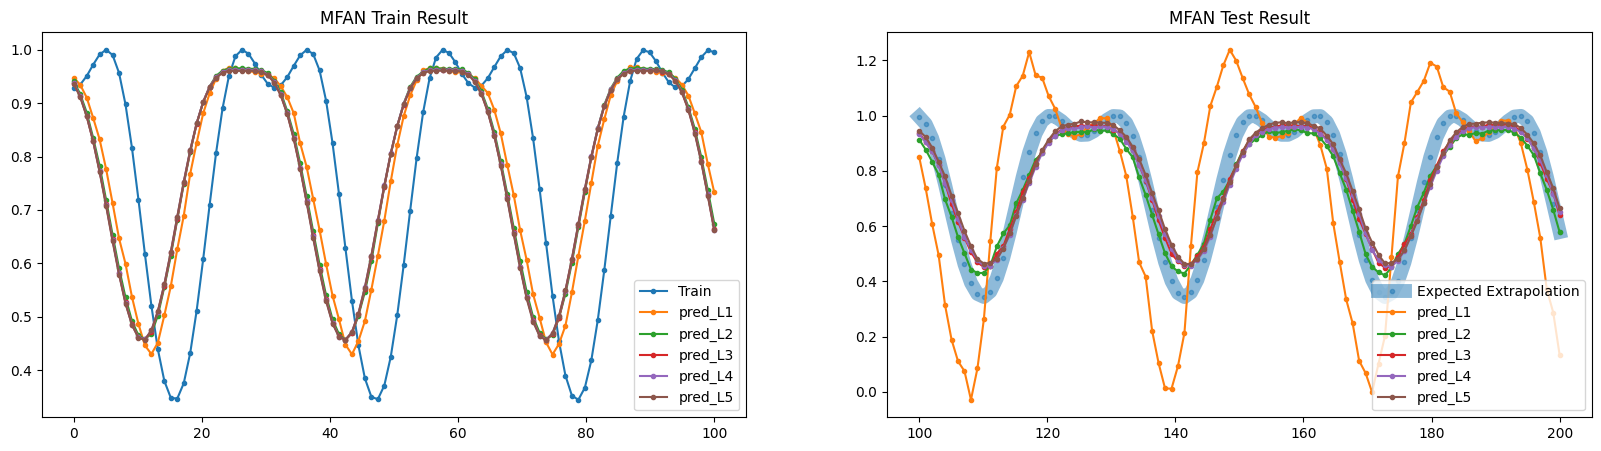

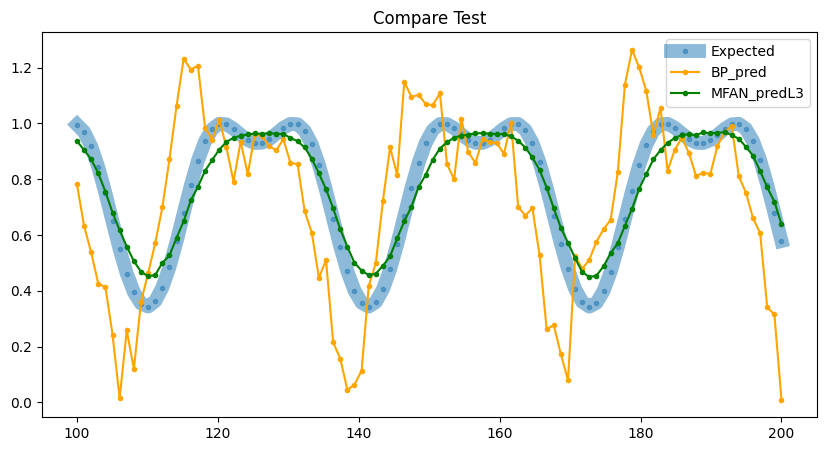

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 330.56it/s]


eval_mse: tr= 0.20484083890914917
eval_mse: te= 0.12888409197330475
eval_mse avg: te avg= 0.24239525198936462
-----------------MFAN----------------------
eval_mse: tr= [2.250260591506958, 0.1335645467042923, 0.14367976784706116, 0.14504991471767426, 0.14625640213489532, 0.14633095264434814]
eval_mse: te= [7.141339302062988, 0.13726703822612762, 0.060558486729860306, 0.062061525881290436, 0.07219646126031876, 0.07170937955379486]  L 3 :  0.062061525881290436


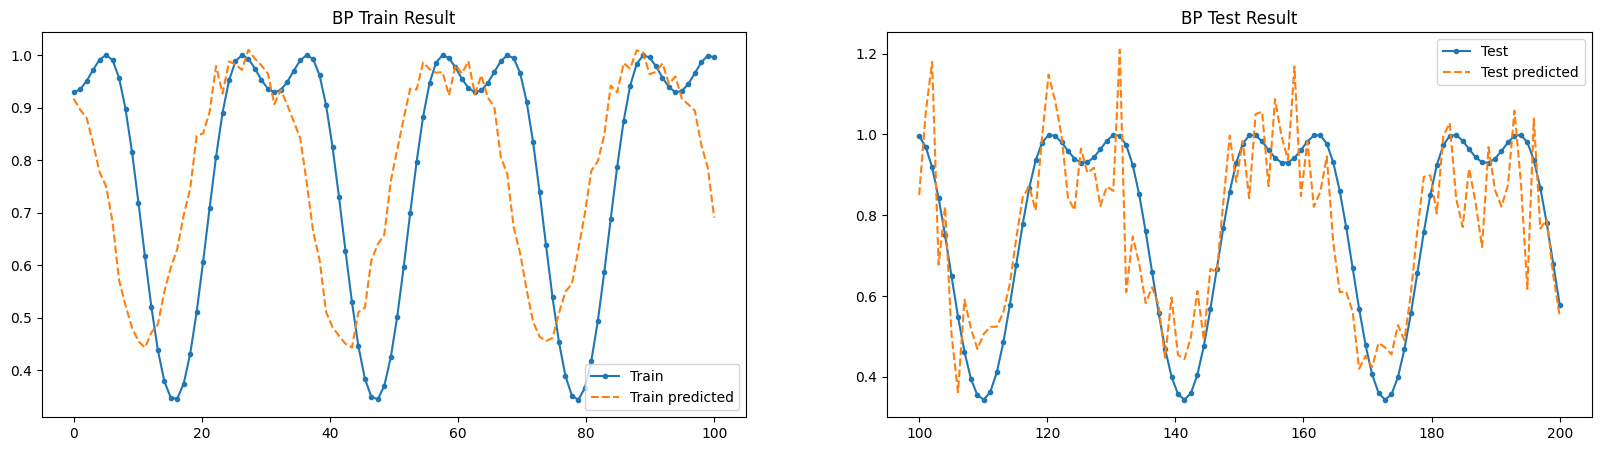

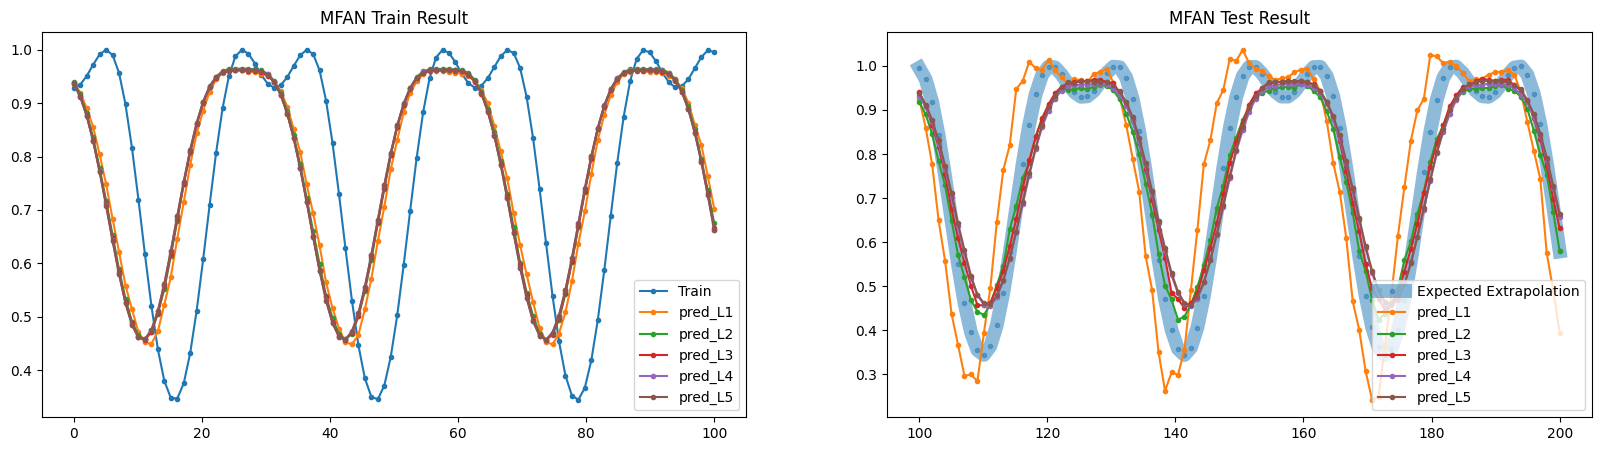

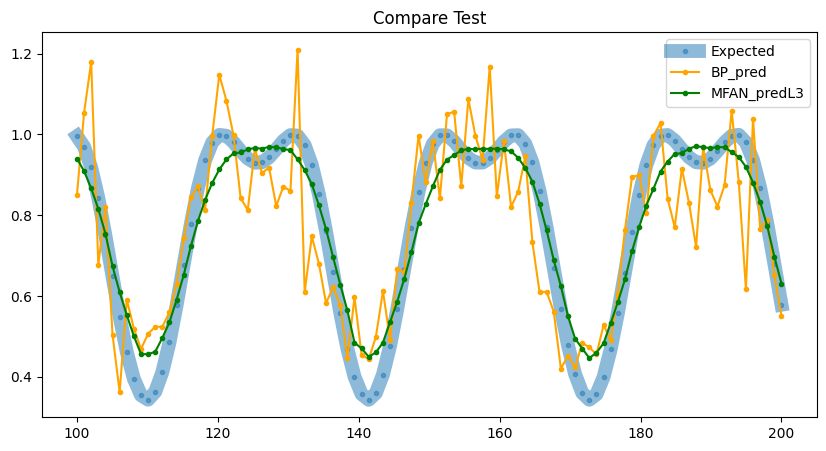

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 229.85it/s]


eval_mse: tr= 0.12794947624206543
eval_mse: te= 0.16476285457611084
eval_mse avg: te avg= 0.23375144600868225
-----------------MFAN----------------------
eval_mse: tr= [1.8526829481124878, 0.12008687108755112, 0.14148010313510895, 0.143897145986557, 0.14613604545593262, 0.1462312489748001]
eval_mse: te= [5.8231916427612305, 0.24520474672317505, 0.05750057101249695, 0.06179255247116089, 0.07226765900850296, 0.07140880078077316]  L 3 :  0.06179255247116089


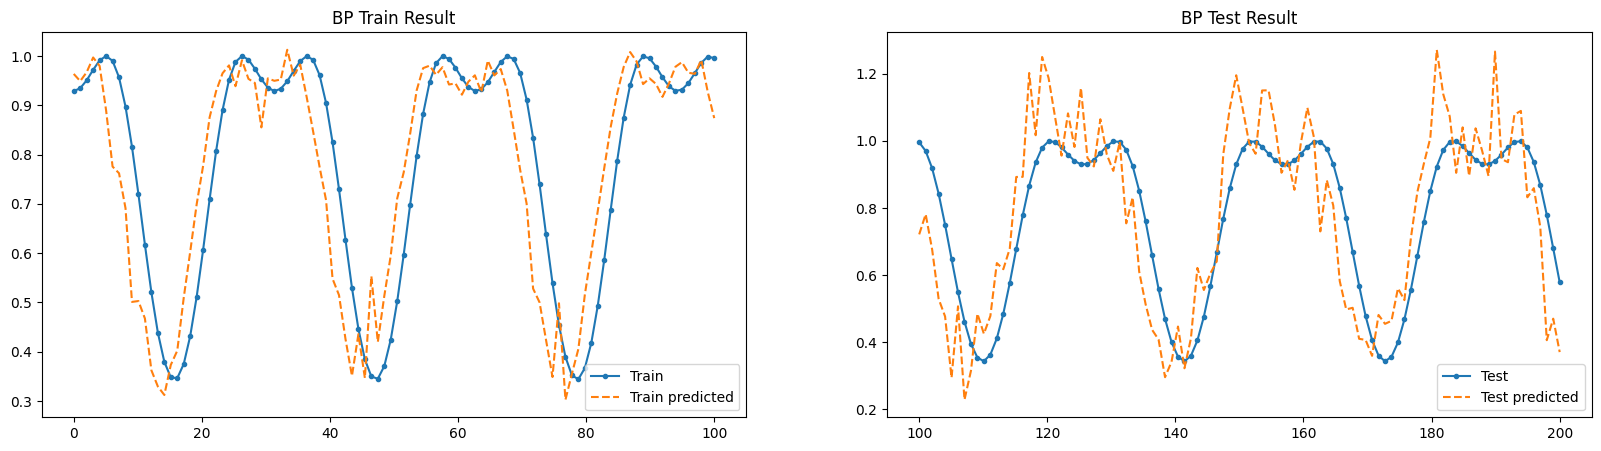

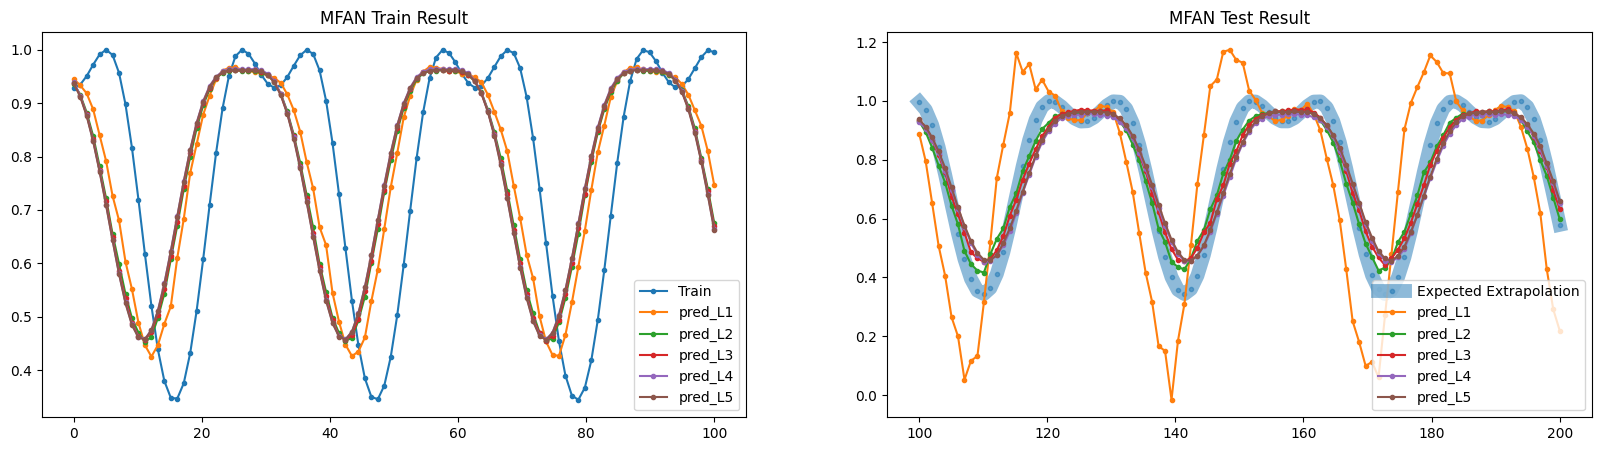

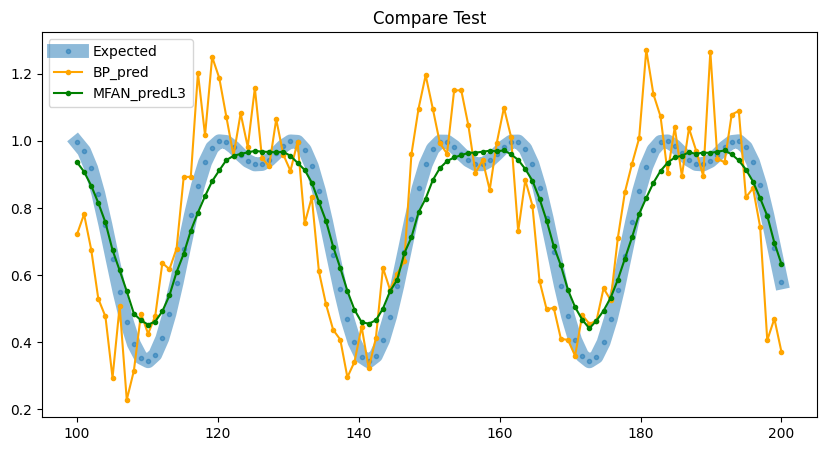

In [ ]:
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.sin(0.8*np.cos(0.2*x)+20), do_plot=False)
bpe_L, mfane_L = [], []
for _ in range(3):
    te_err_BP, te_err_MFAN = get_results(mfan_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5)
    bpe_L.append(te_err_BP)
    mfane_L.append(te_err_MFAN)

In [ ]:
to_rate(bpe_L, mfane_L,
        range=0.7)

range 0.7
BP  [38.72489929 18.41201314 23.53755065] %
MFAN [9.26736636 8.86593227 8.8275075 ] %
MFAN better? (BP error rate - MFAN error rate >0?) [29.45753293  9.54608087 14.71004316] %
--------------avg
BP avg 26.89148769492195 %
MFAN avg 8.986935374282657 %
Avg, MFAN better? (>0?) 17.90455232063929 %


## cos sin c

<ipython-input-137-00b0363ac7e4>:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  f=lambda x: np.cos(0.4*np.sin(0.2*x)+3), do_plot=False)


------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 233.47it/s]
<ipython-input-25-836e78ce95bd>:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_tr = np.sqrt(((y_pred_tr[plot_i]-y_tr[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te = np.sqrt(((y_pred_te[plot_i]-y_te[plot_i])**2).mean()).item() # error measure
<ipython-input-25-836e78ce95bd>:41: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te_avg = np.sqrt(((y_pred_te-y_te)**2).mean()).item() # error measure


eval_mse: tr= 0.04967284947633743
eval_mse: te= 0.018485143780708313
eval_mse avg: te avg= 0.05399633198976517
-----------------MFAN----------------------


<ipython-input-132-efd9dd6dce7c>:15: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse.append(np.sqrt(((y_pred_tr-y_tr_eval)**2).mean()).item()) # error measure
<ipython-input-132-efd9dd6dce7c>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eval_mse_te.append(np.sqrt(((y_pred_te[plot_i]-y_te_eval[plot_i])**2).mean()).item()) # error measure


eval_mse: tr= [1.6391373872756958, 0.019817907363176346, 0.029708590358495712, 0.030833756551146507, 0.03136555105447769, 0.03145994991064072]
eval_mse: te= [3.8370285034179688, 0.15960919857025146, 0.02115507796406746, 0.018558291718363762, 0.017230914905667305, 0.017754310742020607]  L 4 :  0.017230914905667305


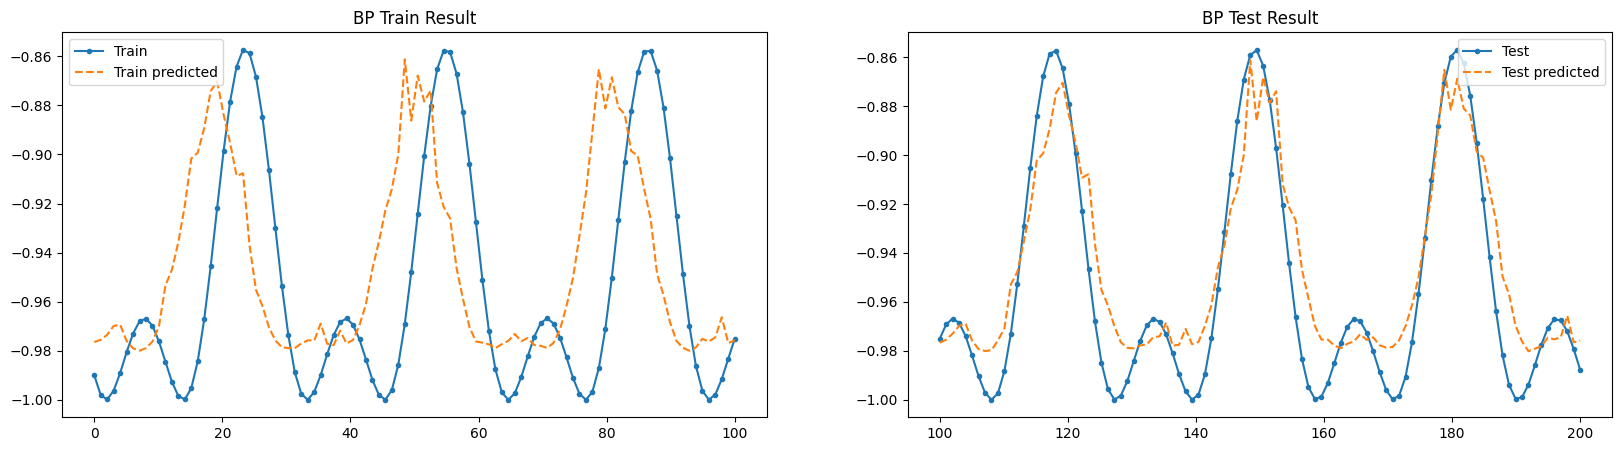

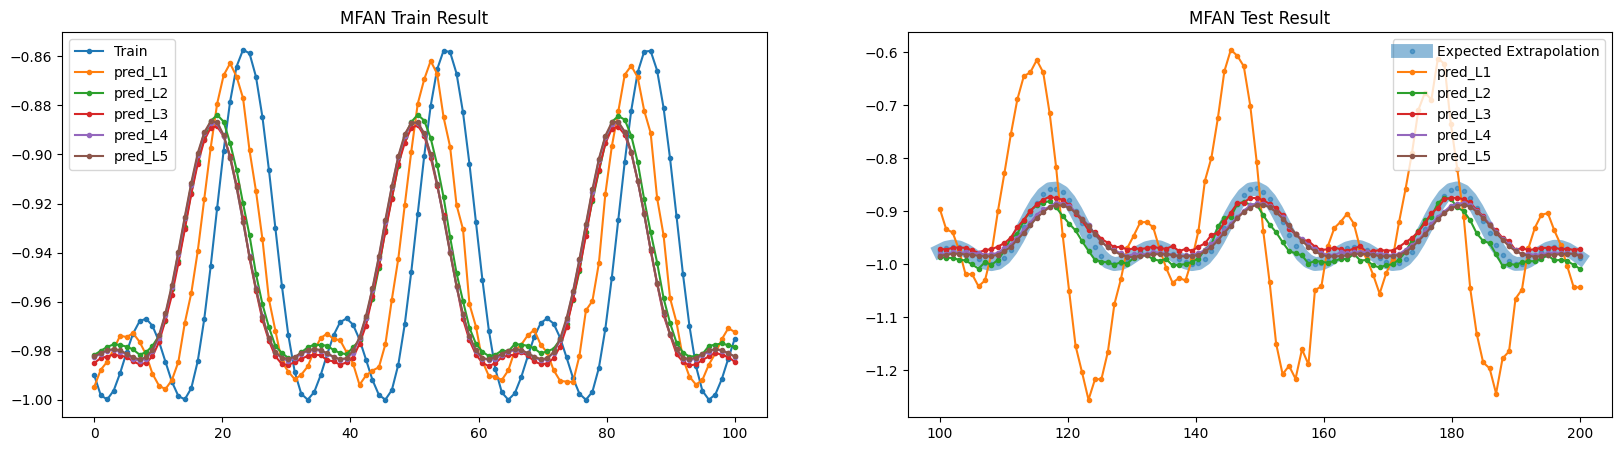

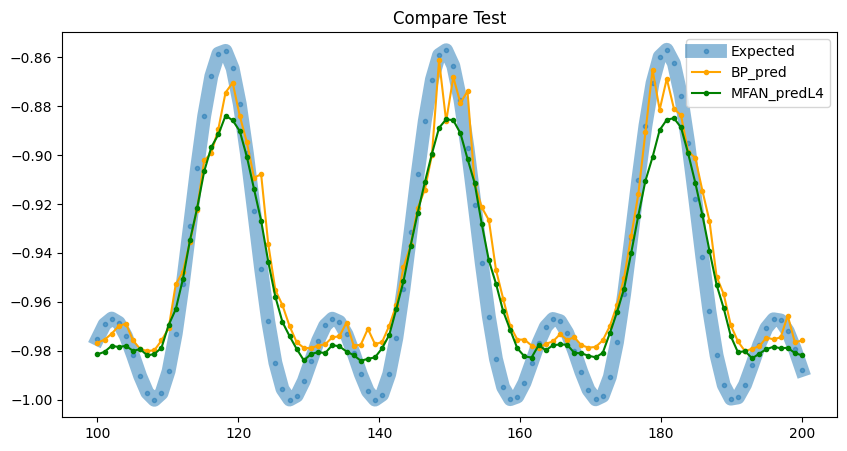

------------------BP----------------------


Train num_iter_batch1: 100%|██████████| 200/200 [00:00<00:00, 329.41it/s]


eval_mse: tr= 0.04786668345332146
eval_mse: te= 0.017877284437417984
eval_mse avg: te avg= 0.05322998762130737
-----------------MFAN----------------------


In [ ]:
x_data_tr, y_data_tr, y_data_tr_neg, x_data_te, y_data_te = create_data(num_data=100,
                                                                        len_data=100,
                                                                        offset=[0.03, 0.07],
                                                                        f=lambda x: np.cos(0.4*np.sin(0.2*x)+3), do_plot=False)
bpe_L, mfane_L = [], []
for _ in range(3):
    te_err_BP, te_err_MFAN = get_results(mfan_lr = [1e-5,1e-4,1e-2], BP_lr=1e-5, comp='h')
    bpe_L.append(te_err_BP)
    mfane_L.append(te_err_MFAN)

In [139]:
to_rate(bpe_L, mfane_L,
        range=0.15)

range 0.15
BP  [12.32342919 11.91818962 11.93945979] %
MFAN [11.4872766  11.74833253 10.47781607] %
MFAN better? (BP error rate - MFAN error rate >0?) [0.83615258 0.16985709 1.46164373] %
--------------avg
BP avg 12.060359534290102 %
MFAN avg 11.23780839973026 %
Avg, MFAN better? (>0?) 0.8225511345598413 %
